<a href="https://colab.research.google.com/github/HJGuan/UZH_Introduction_to_Reinforcement_Learning/blob/main/IntroRL_Assignment_HongjieGuan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning - Chess

## Import 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
from torch import nn

## Environment Initialization and Constants

This part is kept unchanged during this notebook.

In [2]:
# constants
seed = 6
size_board = 4
alpha = 0.003         #parameter for exponential moving average

N_episodes = 100000   # THE NUMBER OF GAMES TO BE PLAYED 




#  environment Initialization

env=Chess_Env(size_board)

S,X,allowed_a = env.Initialise_game()
N_action=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_input_state=np.shape(X)[0]    ## INPUT SIZE
N_hidden_layer=200                ## NUMBER OF HIDDEN NODES


## Test of the Environment


You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

#### 1. 
**Initialise_game**. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.
**S** $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
**X** $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
**allowed_a** $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8   possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

#### 2. 
OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

**R** $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.

**Done** $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
#### 3. 
Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






## DQN Initialization

In [3]:
# initialize the parameters of your neural network and...
# please consider to use a mask of one for the action made and zero otherwise if you are not using vanilla gradient descent...
# we suggest a network with one hidden layer with size 200. 


# Initialise the randomn values in epsilon greedy to gurrantee reproducibility

np.random.seed(seed)
random_values_initial = np.random.uniform(low=0, high=1, size=(N_episodes*10,)) # 10 is just an abitrary number to prevent the "indx out of range" problem

## INITALISE YOUR NEURAL NETWORK...
n_input_layer  = N_input_state
n_hidden_layer = N_hidden_layer
n_output_layer = N_action

# set random seed to guarantee reproducibility

# initial weights Xavier initialization

np.random.seed(seed)
W1_initial = np.random.randn(n_hidden_layer, n_input_layer) * np.sqrt(1 / (n_input_layer))

np.random.seed(seed)
W2_initial = np.random.randn(n_output_layer, n_hidden_layer) * np.sqrt(1 / (n_hidden_layer))

#initialize the biases

bias_W1_initial = np.zeros((n_hidden_layer,))
bias_W2_initial = np.zeros((n_output_layer,))

# only update the seleted actions' Q value
mask = np.zeros((n_output_layer,))



# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE


In [4]:
## DEFINE THE EPSILON-GREEDY POLICY

def EpsilonGreedy_Policy(Qvalues, epsilon, allowed_a,random_value_list,n_index):
    
    ## example:
    # Qvalues = np.array([1,2,3,4])
    # allowed_a = np.array([[0],[1],[1],[0]])
    # As = np.array([1,2])
    # Q_values_of_allowed_actions = [2,3]
    
    As,_ = np.where(allowed_a==1)
    Q_values_of_allowed_actions=[]
    for i in range(len(As)):
        Q_values_of_allowed_actions.append(Qvalues[As[i]])  
    #let rand_a to be true with a probability of epsilon
    rand_value = random_value_list[0]
    random_value_updated = np.delete(random_value_list,0)
    rand_a=rand_value<epsilon
    
    if rand_a==True:
        a=np.random.choice(As)  #epsilon: choosing randomly from As
    else:
        a=As[np.argmax(Q_values_of_allowed_actions)] # 1-epsilon: greedy 
    return a, random_value_updated


## DEFINE THE GREEDY POLICY
def Greedy_Policy(Qvalues,allowed_a):
    
    As,_ = np.where(allowed_a==1)
    Q_values_of_allowed_actions=[]
    for i in range(len(As)):
        Q_values_of_allowed_actions.append(Qvalues[As[i]])
    a=As[np.argmax(Q_values_of_allowed_actions)]    
    return a

            
    

## DQN Training

I first implemented the Deep Q- learning Network.

In [20]:
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE


#initialize the random values for epsilon greedy funtion

random_values=np.copy(random_values_initial) 


#initialize the weight

W1=np.copy(W1_initial)
W2=np.copy(W2_initial)

#initialize the biases

bias_W1 = np.zeros((n_hidden_layer,))
bias_W2 = np.zeros((n_output_layer,))

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])

# Keep track of the network inputs and average error per epoch
errors = np.zeros([N_episodes,1])


# Training

for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    error = 0
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME

    while Done==0:                           ## START THE EPISODE
        
        # Initialise the gradients for each step
        dW1 = np.zeros(W1.shape)
        dW2 = np.zeros(W2.shape)
        dbias_W1 = np.zeros(bias_W1.shape)
        dbias_W2 = np.zeros(bias_W2.shape)
        
        # Neural activation: input layer -> hidden layer
        h1 = np.dot(W1,X)+bias_W1
        # Apply the relu function
        x1 = np.maximum(0,h1)
        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,x1)+bias_W2
        # Apply the relu function
        x2 = np.maximum(0,h2)
        
        Qvalues = x2
        
        # Make an action
        a, rand_value_updated = EpsilonGreedy_Policy(x2,epsilon_f,allowed_a,random_values,n)
        random_values=rand_value_updated
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a)
        
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A) where maxQ(S',a)=0
            e = R-Qvalues[a]
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a]=e
            error += e
            
            delta2 =mask_updated*np.heaviside(h2,0)

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = np.heaviside(h1,0) * np.dot(W2.T, delta2)
            
            dW1 = np.outer(delta1,X)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            
            R_save[n] = np.copy(R)
            N_moves_save[n] = np.copy(i)
            errors[n] = error/i
            print("Episode ",n," Reward:" ,R," Number of steps:",i, " Average Error:",error/i)
            break
        
        # IF THE EPISODE IS NOT OVER...
        else: 
            # this Q(S',a) prediction process is similar to the above one
            h1_next = np.dot(W1,X_next)+bias_W1
            x1_next = np.maximum(0,h1_next)
            h2_next = np.dot(W2,x1_next)+bias_W2
            x2_next = np.maximum(0,h2_next)

            # Q learning(always will use the greedy policy in S')
            a_next = Greedy_Policy(x2_next,allowed_a_next)
            desired_output = R + gamma*x2_next[a_next]

            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A)
            predicted_Q = Qvalues[a]
            e = desired_output - predicted_Q
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a] = e
            error += e
            
            delta2 = np.heaviside(h2,0) * mask_updated

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = np.heaviside(h1,0) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1,X_next)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            # record Reward and steps number
            i +=1      
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)

        
print('Trained_Agent, Average reward:',np.mean(R_save),'Number of steps: ',np.mean(N_moves_save))
        
        
    
    

Streaming output truncated to the last 5000 lines.
Episode  95001  Reward: 1  Number of steps: 3  Average Error: 0.0013323806664264175
Episode  95002  Reward: 1  Number of steps: 1  Average Error: 0.03911708343090681
Episode  95003  Reward: 1  Number of steps: 2  Average Error: 0.018371722971540327
Episode  95004  Reward: 1  Number of steps: 3  Average Error: 0.07425674661394759
Episode  95005  Reward: 1  Number of steps: 3  Average Error: 0.01820947600157134
Episode  95006  Reward: 1  Number of steps: 2  Average Error: 0.004018573771094214
Episode  95007  Reward: 1  Number of steps: 1  Average Error: 0.0061996869383659226
Episode  95008  Reward: 1  Number of steps: 2  Average Error: 0.0019854788080251318
Episode  95009  Reward: 1  Number of steps: 1  Average Error: 0.012117499431626655
Episode  95010  Reward: 1  Number of steps: 4  Average Error: 0.0047326665070270835
Episode  95011  Reward: 1  Number of steps: 4  Average Error: -0.0025060637845493727
Episode  95012  Reward: 1  Number

In [8]:
def exponential_moving_average(array,alpha):
    ema=[]
    ema.append(array[0][0])
    for i in range(1,len(array)):
        v = alpha*array[i][0]+(1-alpha)*ema[i-1]
        ema.append(v)
    return ema

In [9]:
#plot the reward, number of moves and errors in each training

def plot_trainingtime_against_R_and_moves_num(R_save,N_moves_save,errors,alpha):
    ema_R = exponential_moving_average(R_save,alpha)
    ema_moves = exponential_moving_average(N_moves_save,alpha)
    ema_errors = exponential_moving_average(errors,alpha)
    
    
    fig,(ax1, ax2,ax3) = plt.subplots(3, figsize=(20, 10))
    fig.subplots_adjust(hspace=0.5)
    ax1.plot(ema_R,color='r')
    ax1.set_title('Q Learning - Reward',fontsize = 20)
    ax1.set_ylabel('Reward',fontsize = 15)
    ax1.set_xlabel('Episodes',fontsize = 15)
    ax1.grid(True,which='major')
    
    ax2.plot(ema_moves,color='b')
    ax2.set_title('Q Learning - Number of moves',fontsize = 20)
    ax2.set_ylabel('Number of moves',fontsize = 15)
    ax2.set_xlabel('Episodes',fontsize = 15)
    ax2.grid(True,which='major')

    ax3.plot(ema_errors,color='g')
    ax3.set_title('Q Learning - Errors per episode',fontsize = 20)
    ax3.set_ylabel('Average Error per episode',fontsize = 15)
    ax3.set_xlabel('Episodes',fontsize = 15)
    ax3.grid(True,which='major')


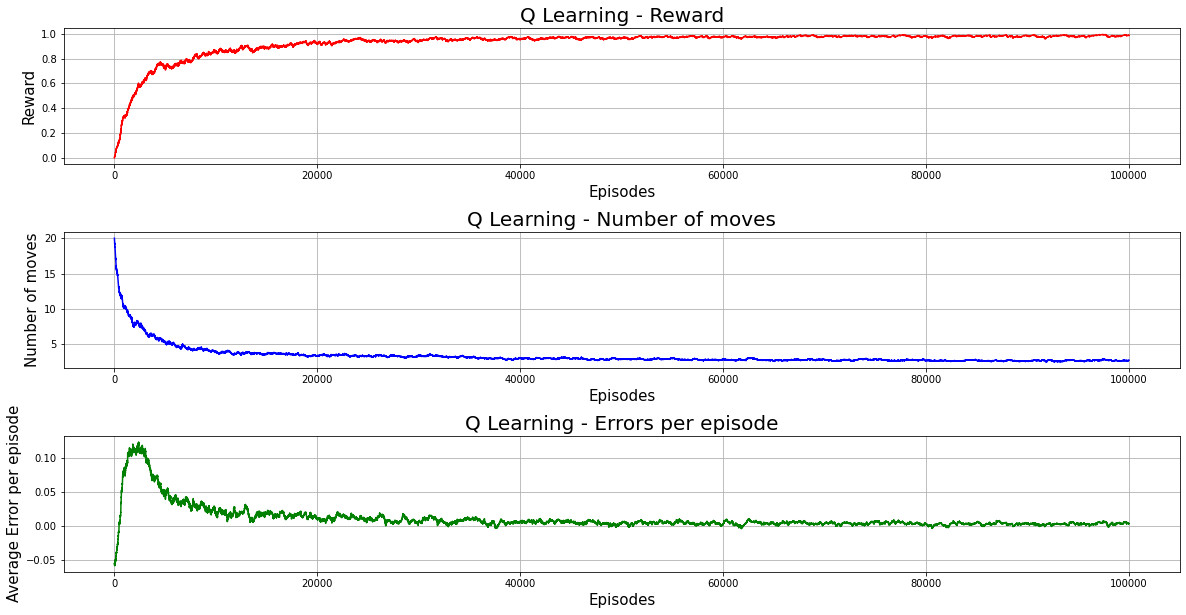

In [29]:
    
plot_trainingtime_against_R_and_moves_num(R_save,N_moves_save,errors,alpha)

### DQN with Leaky Relu as activation function

In the previous training, sometime I met the "Dying ReLU" problem: ReLU activation
function makes many neurons inactive (output 0), which makes
training process inefficient. To solve this problem, I changed
ReLU with leaky ReLU functions to speed up the training.
However, as I changed a random seed, the ”dying ReLU”
problem doesn’t show up again. Hence, the effect is not
obvious.


In [12]:
# initialize the leaky relu negative slope
negative_slope = 0.01

def leaky_relu_derivative(h):
    return (1*(h>=0))+(negative_slope*(h<0))

In [13]:
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE


#initialize the random values for epsilon greedy funtion

random_values=np.copy(random_values_initial) 


#initialize the weight

W1=np.copy(W1_initial)
W2=np.copy(W2_initial)

#initialize the biases

bias_W1 = np.zeros((n_hidden_layer,))
bias_W2 = np.zeros((n_output_layer,))

# SAVING VARIABLES
R_save_wtih_leakyRelu = np.zeros([N_episodes, 1])
N_moves_save_wtih_leakyRelu = np.zeros([N_episodes, 1])

# Keep track of the network inputs and average error per epoch
errors_leakyRelu = np.zeros([N_episodes,1])




for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    error =0
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    while Done==0:                           ## START THE EPISODE
        
        # Initialise the gradients for each step
        dW1 = np.zeros(W1.shape)
        dW2 = np.zeros(W2.shape)
        dbias_W1 = np.zeros(bias_W1.shape)
        dbias_W2 = np.zeros(bias_W2.shape)
        
        # Neural activation: input layer -> hidden layer
        h1 = np.dot(W1,X)+bias_W1
        # Apply the leaky relu function
        x1 = np.maximum(0,h1)+negative_slope*np.minimum(0,h1)
        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,x1)+bias_W2
        # Apply the leaky relu function
        x2 = np.maximum(0,h2)+negative_slope*np.minimum(0,h2)
        
        Qvalues = x2
        
        # Make an action
        a, rand_value_updated = EpsilonGreedy_Policy(x2,epsilon_f,allowed_a,random_values,n)
        random_values=rand_value_updated
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a)
        
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A) where maxQ(S',a)=0
            e = R-Qvalues[a]
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a]=e
            error += e
            delta2 =mask_updated*leaky_relu_derivative(h2)

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            
            delta1 = leaky_relu_derivative(h1) * np.dot(W2.T, delta2)
            
            dW1 = np.outer(delta1,X)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            
            R_save_wtih_leakyRelu[n] = np.copy(R)
            N_moves_save_wtih_leakyRelu[n] = np.copy(i)
            errors_leakyRelu[n] = error/i
            print("Episode ",n," Reward:" ,R," Number of steps:",i, " Average Error:",error/i)
            break
        
        # IF THE EPISODE IS NOT OVER...
        else: 
            # this Q(S',a) prediction process is similar to the above one
            h1_next = np.dot(W1,X_next)+bias_W1
            x1_next = np.maximum(0,h1_next)+negative_slope*np.minimum(0,h1_next)
            h2_next = np.dot(W2,x1_next)+bias_W2
            x2_next = np.maximum(0,h2_next)+negative_slope*np.minimum(0,h2_next)

            # Q learning(always will use the greedy policy in S')
            a_next = Greedy_Policy(x2_next,allowed_a_next)
            desired_output = R + gamma*x2_next[a_next]

            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A)
            predicted_Q = Qvalues[a]
            e = desired_output - predicted_Q
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a] = e
            error += e
            delta2 = leaky_relu_derivative(h2) * mask_updated

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = leaky_relu_derivative(h1) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1,X_next)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            # record Reward and steps number
            i +=1      
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)

        
print('Trained_Agent, Average reward:',np.mean(R_save_wtih_leakyRelu),'Number of steps: ',np.mean(N_moves_save_wtih_leakyRelu))
        
        
    
    

Streaming output truncated to the last 5000 lines.
Episode  95001  Reward: 1  Number of steps: 1  Average Error: 0.03873287284341098
Episode  95002  Reward: 1  Number of steps: 6  Average Error: 0.0015025420447198161
Episode  95003  Reward: 1  Number of steps: 1  Average Error: 0.005055520253394619
Episode  95004  Reward: 1  Number of steps: 4  Average Error: 0.0025941625505777888
Episode  95005  Reward: 1  Number of steps: 3  Average Error: 0.02286012031864711
Episode  95006  Reward: 1  Number of steps: 2  Average Error: 0.18452701911579322
Episode  95007  Reward: 1  Number of steps: 3  Average Error: -0.008914605188181842
Episode  95008  Reward: 1  Number of steps: 3  Average Error: 0.0019426176299244629
Episode  95009  Reward: 1  Number of steps: 2  Average Error: 0.010528954558271075
Episode  95010  Reward: 1  Number of steps: 4  Average Error: 0.0012950378371481275
Episode  95011  Reward: 1  Number of steps: 1  Average Error: -0.005413807982443952
Episode  95012  Reward: 1  Number

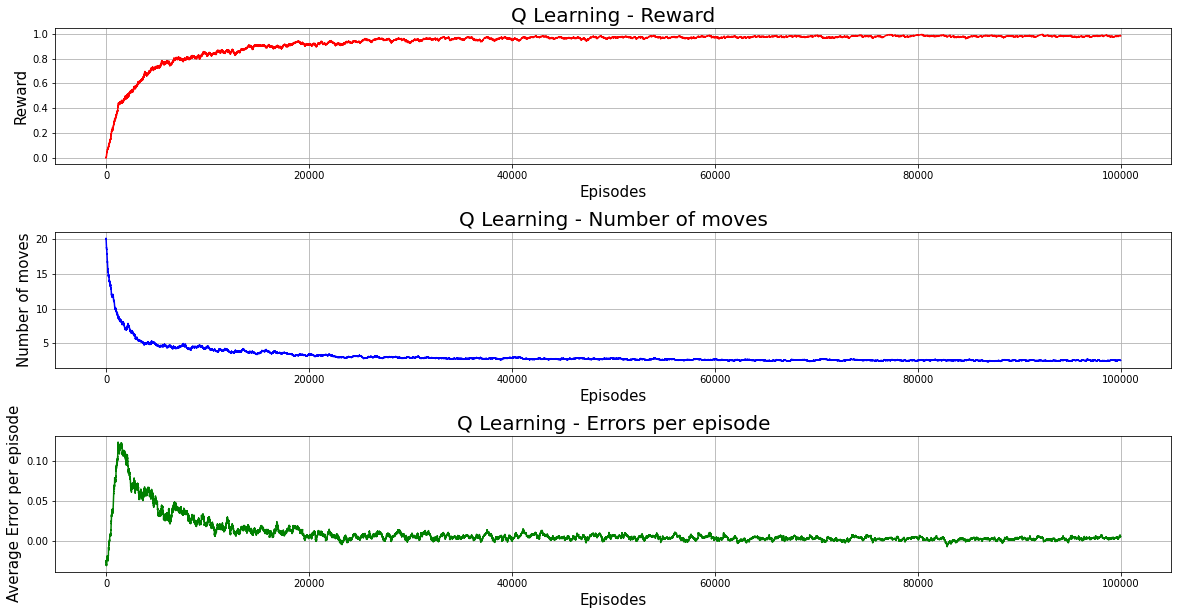

In [30]:
plot_trainingtime_against_R_and_moves_num(R_save_wtih_leakyRelu,N_moves_save_wtih_leakyRelu,errors_leakyRelu,alpha)

## Experiments of changing   $\gamma$ and $\beta$

The discount factor γ is a 0 to 1 parameter to discount the
future rewards to the present state. For example, if γ=0.8, 1
unit of reward from the next state will only equal to 0.8 unit
of reward from the current state. As γ increases, the future
reward is going to have an increasing effect on Q updating. We will first increase the γ from 0.85 to 0.90 and then decrease it to 0.65 to compare the difference in the result.



### Scenario 1.1: changing $\gamma$ from 0.85 to 0.9

In [18]:
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.9        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE


#initialize the random values for epsilon greedy funtion

random_values=np.copy(random_values_initial) 


#initialize the weight

W1=np.copy(W1_initial)
W2=np.copy(W2_initial)

#initialize the biases

bias_W1 = np.zeros((n_hidden_layer,))
bias_W2 = np.zeros((n_output_layer,))

# SAVING VARIABLES
R_save_gamma_change1 = np.zeros([N_episodes, 1])
N_moves_save_gamma_change1 = np.zeros([N_episodes, 1])

# Keep track of the network inputs and average error per epoch
errors_gamma_change1 = np.zeros([N_episodes,1])



for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    error =0
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    while Done==0:                           ## START THE EPISODE
        
        # Initialise the gradients for each step
        dW1 = np.zeros(W1.shape)
        dW2 = np.zeros(W2.shape)
        dbias_W1 = np.zeros(bias_W1.shape)
        dbias_W2 = np.zeros(bias_W2.shape)
        
        # Neural activation: input layer -> hidden layer
        h1 = np.dot(W1,X)+bias_W1
        # Apply the relu function
        x1 = np.maximum(0,h1)
        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,x1)+bias_W2
        # Apply the relu function
        x2 = np.maximum(0,h2)
        
        Qvalues = x2
        
        # Make an action
        a, rand_value_updated = EpsilonGreedy_Policy(x2,epsilon_f,allowed_a,random_values,n)
        random_values=rand_value_updated
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a)
        
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A) where maxQ(S',a)=0
            e = R-Qvalues[a]
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a]=e
            error += e
            
            delta2 =mask_updated*np.heaviside(h2,0)

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = np.heaviside(h1,0) * np.dot(W2.T, delta2)
            
            dW1 = np.outer(delta1,X)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            
            R_save_gamma_change1[n] = np.copy(R)
            N_moves_save_gamma_change1[n] = np.copy(i)
            errors_gamma_change1[n] = error/i
            print("Episode ",n," Reward:" ,R," Number of steps:",i, " Average Error:",error/i)
            break
        
        # IF THE EPISODE IS NOT OVER...
        else: 
            # this Q(S',a) prediction process is similar to the above one
            h1_next = np.dot(W1,X_next)+bias_W1
            x1_next = np.maximum(0,h1_next)
            h2_next = np.dot(W2,x1_next)+bias_W2
            x2_next = np.maximum(0,h2_next)

            # Q learning(always will use the greedy policy in S')
            a_next = Greedy_Policy(x2_next,allowed_a_next)
            desired_output = R + gamma*x2_next[a_next]

            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A)
            predicted_Q = Qvalues[a]
            e = desired_output - predicted_Q
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a] = e
            error += e
            
            delta2 = np.heaviside(h2,0) * mask_updated

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = np.heaviside(h1,0) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1,X_next)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            # record Reward and steps number
            i +=1        
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)


print('Trained_Agent, Average reward:',np.mean(R_save_gamma_change1),'Number of steps: ',np.mean(N_moves_save_gamma_change1))
        
        
    
    

Streaming output truncated to the last 5000 lines.
Episode  95001  Reward: 1  Number of steps: 4  Average Error: -0.02417725532619175
Episode  95002  Reward: 1  Number of steps: 5  Average Error: -0.009348194298688717
Episode  95003  Reward: 1  Number of steps: 2  Average Error: -0.010960112100660613
Episode  95004  Reward: 1  Number of steps: 1  Average Error: 0.0016482567922585512
Episode  95005  Reward: 1  Number of steps: 1  Average Error: 0.0031291836387702388
Episode  95006  Reward: 1  Number of steps: 4  Average Error: -0.0010206484837934071
Episode  95007  Reward: 1  Number of steps: 1  Average Error: 0.008795391766768912
Episode  95008  Reward: 1  Number of steps: 3  Average Error: 0.018132359968715466
Episode  95009  Reward: 1  Number of steps: 1  Average Error: -0.008371700936244064
Episode  95010  Reward: 1  Number of steps: 4  Average Error: -0.004201364568597349
Episode  95011  Reward: 1  Number of steps: 4  Average Error: 0.0018082745517198073
Episode  95012  Reward: 1  

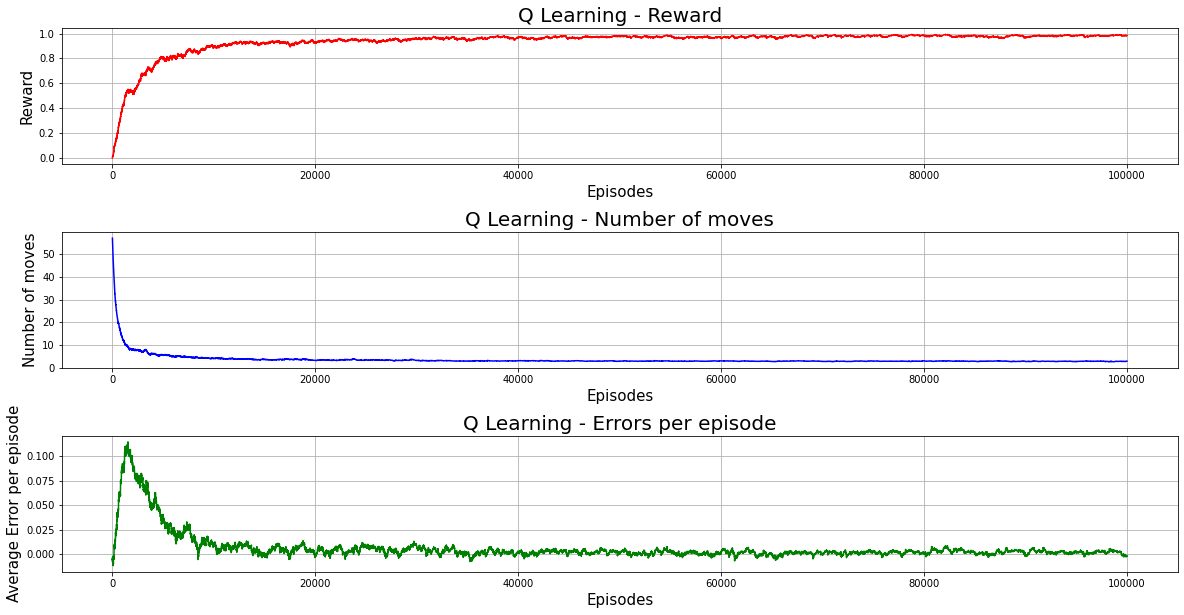

In [31]:
plot_trainingtime_against_R_and_moves_num(R_save_gamma_change1,N_moves_save_gamma_change1,errors_gamma_change1,alpha)

### Scenario 1.2: changing $\gamma$ from 0.85 to 0.65

In [32]:
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.65        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE


#initialize the random values for epsilon greedy funtion

random_values=np.copy(random_values_initial) 


#initialize the weight

W1=np.copy(W1_initial)
W2=np.copy(W2_initial)

#initialize the biases

bias_W1 = np.zeros((n_hidden_layer,))
bias_W2 = np.zeros((n_output_layer,))

# SAVING VARIABLES
R_save_gamma_change2 = np.zeros([N_episodes, 1])
N_moves_save_gamma_change2 = np.zeros([N_episodes, 1])

# Keep track of the network inputs and average error per epoch
errors_gamma_change2 = np.zeros([N_episodes,1])



for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    error =0
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    while Done==0:                           ## START THE EPISODE
        
        # Initialise the gradients for each step
        dW1 = np.zeros(W1.shape)
        dW2 = np.zeros(W2.shape)
        dbias_W1 = np.zeros(bias_W1.shape)
        dbias_W2 = np.zeros(bias_W2.shape)
        
        # Neural activation: input layer -> hidden layer
        h1 = np.dot(W1,X)+bias_W1
        # Apply the relu function
        x1 = np.maximum(0,h1)
        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,x1)+bias_W2
        # Apply the relu function
        x2 = np.maximum(0,h2)
        
        Qvalues = x2
        
        # Make an action
        a, rand_value_updated = EpsilonGreedy_Policy(x2,epsilon_f,allowed_a,random_values,n)
        random_values=rand_value_updated
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a)
        
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A) where maxQ(S',a)=0
            e = R-Qvalues[a]
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a]=e
            error += e
            
            delta2 =mask_updated*np.heaviside(h2,0)

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = np.heaviside(h1,0) * np.dot(W2.T, delta2)
            
            dW1 = np.outer(delta1,X)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            
            R_save_gamma_change2[n] = np.copy(R)
            N_moves_save_gamma_change2[n] = np.copy(i)
            errors_gamma_change2[n] = error/i
            print("Episode ",n," Reward:" ,R," Number of steps:",i, " Average Error:",error/i)
            break
        
        # IF THE EPISODE IS NOT OVER...
        else: 
            # this Q(S',a) prediction process is similar to the above one
            h1_next = np.dot(W1,X_next)+bias_W1
            x1_next = np.maximum(0,h1_next)
            h2_next = np.dot(W2,x1_next)+bias_W2
            x2_next = np.maximum(0,h2_next)

            # Q learning(always will use the greedy policy in S')
            a_next = Greedy_Policy(x2_next,allowed_a_next)
            desired_output = R + gamma*x2_next[a_next]

            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A)
            predicted_Q = Qvalues[a]
            e = desired_output - predicted_Q
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a] = e
            error += e
            
            delta2 = np.heaviside(h2,0) * mask_updated

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = np.heaviside(h1,0) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1,X_next)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            # record Reward and steps number
            i +=1        
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)


print('Trained_Agent, Average reward:',np.mean(R_save_gamma_change2),'Number of steps: ',np.mean(N_moves_save_gamma_change2))
        
        
    
    

Streaming output truncated to the last 5000 lines.
Episode  95001  Reward: 1  Number of steps: 2  Average Error: -0.02266852041580225
Episode  95002  Reward: 1  Number of steps: 4  Average Error: 0.011306234886091157
Episode  95003  Reward: 1  Number of steps: 3  Average Error: 0.126540109877782
Episode  95004  Reward: 1  Number of steps: 1  Average Error: -0.015912326999970583
Episode  95005  Reward: 1  Number of steps: 6  Average Error: 0.012464857575395921
Episode  95006  Reward: 1  Number of steps: 1  Average Error: 0.011341722157545475
Episode  95007  Reward: 1  Number of steps: 1  Average Error: 0.010621747119267888
Episode  95008  Reward: 1  Number of steps: 2  Average Error: -0.010247603105502823
Episode  95009  Reward: 1  Number of steps: 4  Average Error: 0.0069032560292351525
Episode  95010  Reward: 1  Number of steps: 2  Average Error: -0.0020352983437398886
Episode  95011  Reward: 1  Number of steps: 1  Average Error: 0.014724474519389075
Episode  95012  Reward: 1  Number 

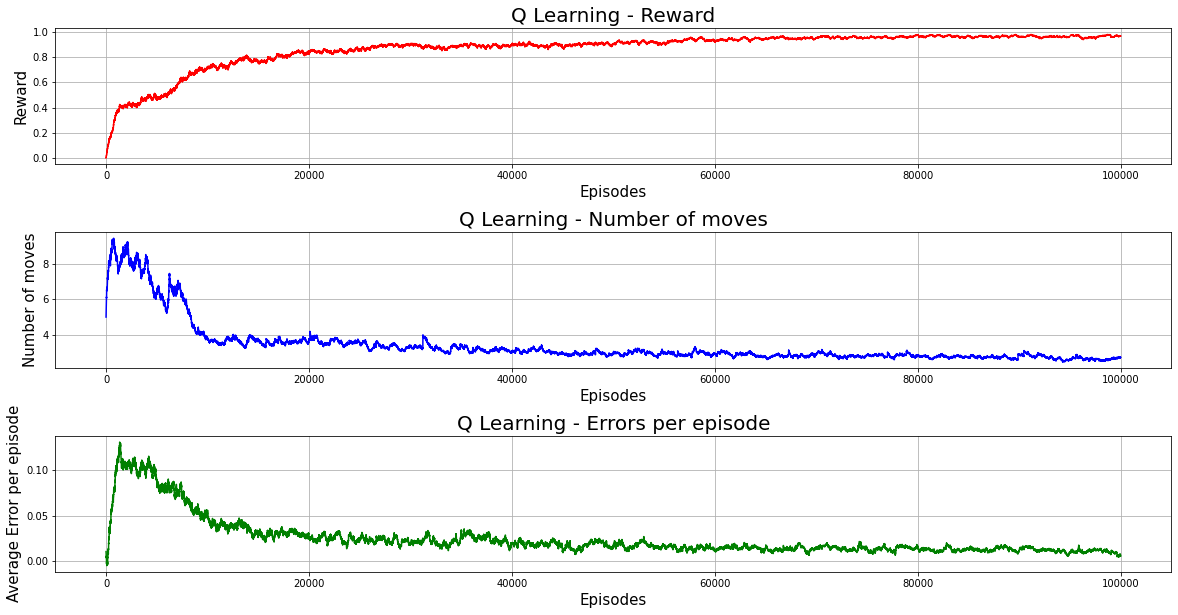

In [33]:
plot_trainingtime_against_R_and_moves_num(R_save_gamma_change2,N_moves_save_gamma_change2,errors_gamma_change2,alpha)

### Scenario 2.1 : changing $\beta$ from 0.00005 to 0.0005

According to the definition of the ϵ decaying factor β, the
larger the β is, the faster ϵ decays as training time increases.
According to the definition of ϵ-greedy policy, greedy policy is
identical to 0-greedy policy(when ϵ equals 0). Consequently,
as the ϵ decays, the ϵ-greedy policy will converge to greedy
policy. We will change the β from 0.00005 to 0.0005, 0.005, 0 respectively.

In [34]:
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.0005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE


#initialize the random values for epsilon greedy funtion

random_values=np.copy(random_values_initial) 


#initialize the weight

W1=np.copy(W1_initial)
W2=np.copy(W2_initial)

#initialize the biases

bias_W1 = np.zeros((n_hidden_layer,))
bias_W2 = np.zeros((n_output_layer,))

# SAVING VARIABLES
R_save_beta_change1 = np.zeros([N_episodes, 1])
N_moves_save_beta_change1 = np.zeros([N_episodes, 1])

# Keep track of the network inputs and average error per epoch
errors_beta_change1 = np.zeros([N_episodes,1])







for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    error =0
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    while Done==0:                           ## START THE EPISODE
        
        # Initialise the gradients for each step
        dW1 = np.zeros(W1.shape)
        dW2 = np.zeros(W2.shape)
        dbias_W1 = np.zeros(bias_W1.shape)
        dbias_W2 = np.zeros(bias_W2.shape)
        
        # Neural activation: input layer -> hidden layer
        h1 = np.dot(W1,X)+bias_W1
        # Apply the relu function
        x1 = np.maximum(0,h1)
        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,x1)+bias_W2
        # Apply the relu function
        x2 = np.maximum(0,h2)
        
        Qvalues = x2
        
        # Make an action
        a, rand_value_updated = EpsilonGreedy_Policy(x2,epsilon_f,allowed_a,random_values,n)
        random_values=rand_value_updated
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a)
        
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A) where maxQ(S',a)=0
            e = R-Qvalues[a]
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a]=e
            error += e
            
            delta2 =mask_updated*np.heaviside(h2,0)

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = np.heaviside(h1,0) * np.dot(W2.T, delta2)
            
            dW1 = np.outer(delta1,X)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            
            R_save_beta_change1[n] = np.copy(R)
            N_moves_save_beta_change1[n] = np.copy(i)
            errors_beta_change1[n] = error/i
            print("Episode ",n," Reward:" ,R," Number of steps:",i, " Average Error:",error/i)
            break
        
        # IF THE EPISODE IS NOT OVER...
        else: 
            # this Q(S',a) prediction process is similar to the above one
            h1_next = np.dot(W1,X_next)+bias_W1
            x1_next = np.maximum(0,h1_next)
            h2_next = np.dot(W2,x1_next)+bias_W2
            x2_next = np.maximum(0,h2_next)

            # Q learning(always will use the greedy policy in S')
            a_next = Greedy_Policy(x2_next,allowed_a_next)
            desired_output = R + gamma*x2_next[a_next]

            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A)
            predicted_Q = Qvalues[a]
            e = desired_output - predicted_Q
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a] = e
            error += e
            
            delta2 = np.heaviside(h2,0) * mask_updated

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = np.heaviside(h1,0) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1,X_next)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            # record Reward and steps number
            i +=1        
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)


print('Trained_Agent, Average reward:',np.mean(R_save_beta_change1),'Number of steps: ',np.mean(N_moves_save_beta_change1))
        
        
    
    

Streaming output truncated to the last 5000 lines.
Episode  95001  Reward: 1  Number of steps: 2  Average Error: -0.0036535256687025286
Episode  95002  Reward: 1  Number of steps: 1  Average Error: -0.0011971127841825524
Episode  95003  Reward: 1  Number of steps: 1  Average Error: -0.010242757227686194
Episode  95004  Reward: 1  Number of steps: 3  Average Error: -0.007392356552421098
Episode  95005  Reward: 1  Number of steps: 5  Average Error: 0.004834343287266096
Episode  95006  Reward: 1  Number of steps: 5  Average Error: 0.15033257566114497
Episode  95007  Reward: 1  Number of steps: 4  Average Error: 0.00875077412601305
Episode  95008  Reward: 1  Number of steps: 2  Average Error: 0.020708660602301532
Episode  95009  Reward: 1  Number of steps: 4  Average Error: 0.009019234023928263
Episode  95010  Reward: 1  Number of steps: 1  Average Error: -0.006887663508469588
Episode  95011  Reward: 1  Number of steps: 4  Average Error: -0.005776713037031145
Episode  95012  Reward: 1  Num

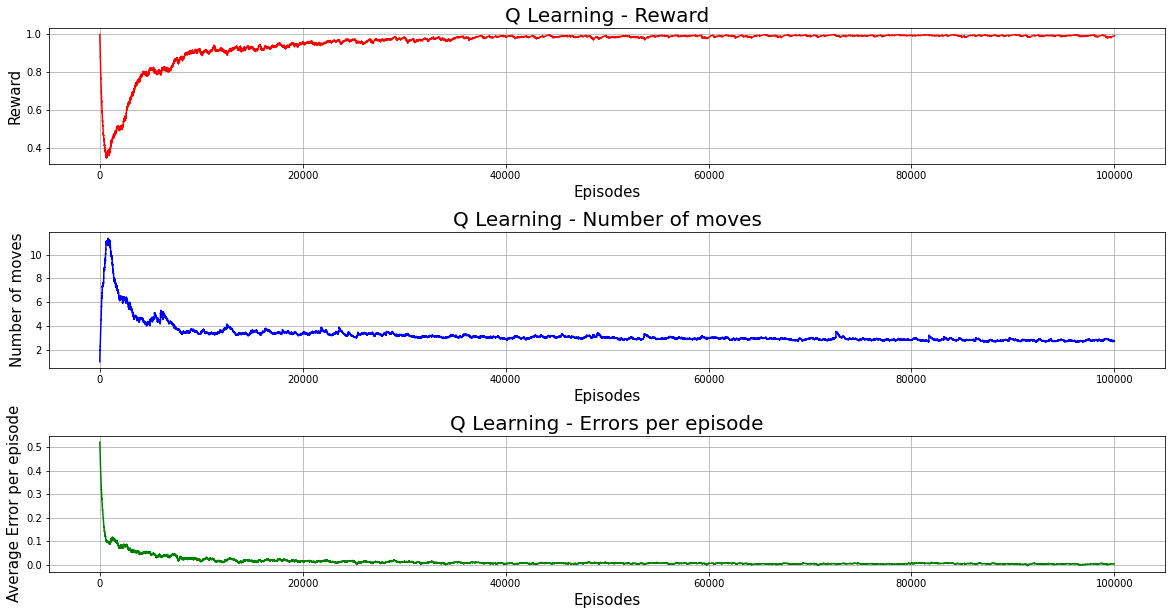

In [35]:
plot_trainingtime_against_R_and_moves_num(R_save_beta_change1,N_moves_save_beta_change1,errors_beta_change1,alpha)

### Scenario 2.2 : changing $\beta$ from 0.00005 to 0.005

In [37]:
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE


#initialize the random values for epsilon greedy funtion

random_values=np.copy(random_values_initial) 


#initialize the weight

W1=np.copy(W1_initial)
W2=np.copy(W2_initial)

#initialize the biases

bias_W1 = np.zeros((n_hidden_layer,))
bias_W2 = np.zeros((n_output_layer,))

# SAVING VARIABLES
R_save_beta_change2 = np.zeros([N_episodes, 1])
N_moves_save_beta_change2 = np.zeros([N_episodes, 1])

# Keep track of the network inputs and average error per epoch
errors_beta_change2 = np.zeros([N_episodes,1])







for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    error =0
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    while Done==0:                           ## START THE EPISODE
        
        # Initialise the gradients for each step
        dW1 = np.zeros(W1.shape)
        dW2 = np.zeros(W2.shape)
        dbias_W1 = np.zeros(bias_W1.shape)
        dbias_W2 = np.zeros(bias_W2.shape)
        
        # Neural activation: input layer -> hidden layer
        h1 = np.dot(W1,X)+bias_W1
        # Apply the relu function
        x1 = np.maximum(0,h1)
        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,x1)+bias_W2
        # Apply the relu function
        x2 = np.maximum(0,h2)
        
        Qvalues = x2
        
        # Make an action
        a, rand_value_updated = EpsilonGreedy_Policy(x2,epsilon_f,allowed_a,random_values,n)
        random_values=rand_value_updated
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a)
        
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A) where maxQ(S',a)=0
            e = R-Qvalues[a]
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a]=e
            error += e
            
            delta2 =mask_updated*np.heaviside(h2,0)

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = np.heaviside(h1,0) * np.dot(W2.T, delta2)
            
            dW1 = np.outer(delta1,X)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            
            R_save_beta_change2[n] = np.copy(R)
            N_moves_save_beta_change2[n] = np.copy(i)
            errors_beta_change2[n] = error/i
            print("Episode ",n," Reward:" ,R," Number of steps:",i, " Average Error:",error/i)
            break
        
        # IF THE EPISODE IS NOT OVER...
        else: 
            # this Q(S',a) prediction process is similar to the above one
            h1_next = np.dot(W1,X_next)+bias_W1
            x1_next = np.maximum(0,h1_next)
            h2_next = np.dot(W2,x1_next)+bias_W2
            x2_next = np.maximum(0,h2_next)

            # Q learning(always will use the greedy policy in S')
            a_next = Greedy_Policy(x2_next,allowed_a_next)
            desired_output = R + gamma*x2_next[a_next]

            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A)
            predicted_Q = Qvalues[a]
            e = desired_output - predicted_Q
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a] = e
            error += e
            
            delta2 = np.heaviside(h2,0) * mask_updated

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = np.heaviside(h1,0) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1,X_next)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            # record Reward and steps number
            i +=1        
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)


print('Trained_Agent, Average reward:',np.mean(R_save_beta_change2),'Number of steps: ',np.mean(N_moves_save_beta_change2))
        
        
    
    

Streaming output truncated to the last 5000 lines.
Episode  95001  Reward: 1  Number of steps: 5  Average Error: 0.0027769055139388764
Episode  95002  Reward: 1  Number of steps: 4  Average Error: -0.012921670518308948
Episode  95003  Reward: 1  Number of steps: 1  Average Error: 0.0010729385056882368
Episode  95004  Reward: 1  Number of steps: 1  Average Error: 0.04382798025597878
Episode  95005  Reward: 1  Number of steps: 4  Average Error: 0.030731594268852414
Episode  95006  Reward: 1  Number of steps: 4  Average Error: 0.04157267622950879
Episode  95007  Reward: 1  Number of steps: 4  Average Error: 0.021183987263418996
Episode  95008  Reward: 1  Number of steps: 2  Average Error: -0.025124738810604508
Episode  95009  Reward: 1  Number of steps: 4  Average Error: -0.016269493364887228
Episode  95010  Reward: 1  Number of steps: 1  Average Error: 0.03631444818691376
Episode  95011  Reward: 1  Number of steps: 3  Average Error: -0.002217491030489923
Episode  95012  Reward: 1  Number

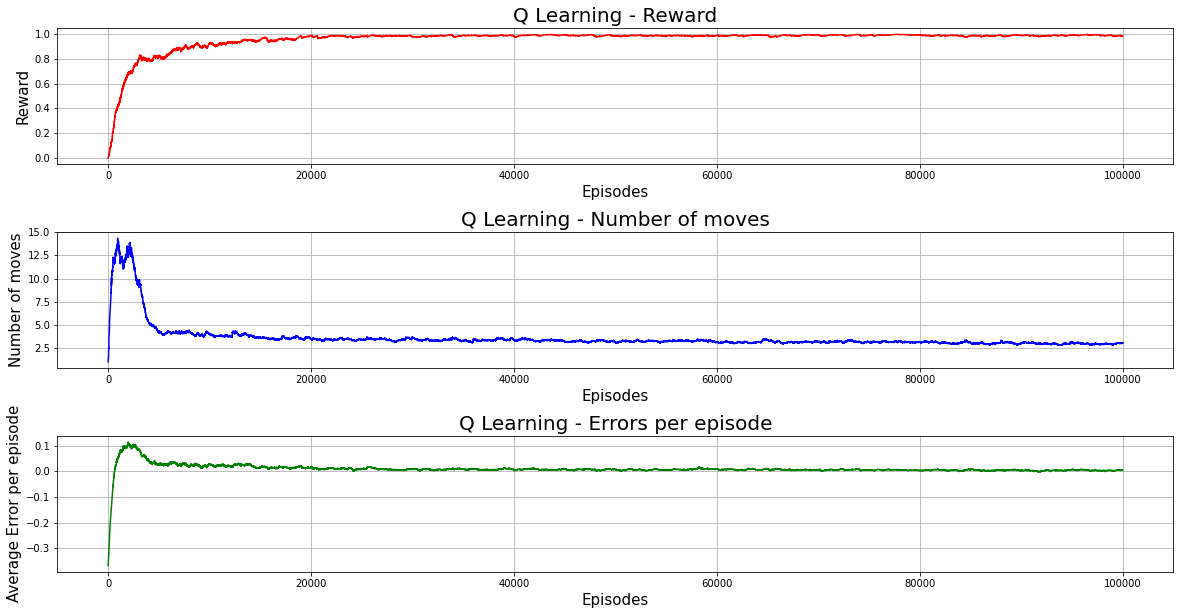

In [38]:
plot_trainingtime_against_R_and_moves_num(R_save_beta_change2,N_moves_save_beta_change2,errors_beta_change2,alpha)

### Scenario 2.3 : changing $\beta$ from 0.00005 to 0

In [23]:
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE


#initialize the random values for epsilon greedy funtion

random_values=np.copy(random_values_initial) 


#initialize the weight

W1=np.copy(W1_initial)
W2=np.copy(W2_initial)

#initialize the biases

bias_W1 = np.zeros((n_hidden_layer,))
bias_W2 = np.zeros((n_output_layer,))

# SAVING VARIABLES
R_save_beta_change3 = np.zeros([N_episodes, 1])
N_moves_save_beta_change3 = np.zeros([N_episodes, 1])

# Keep track of the network inputs and average error per epoch
errors_beta_change3 = np.zeros([N_episodes,1])



for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    error =0
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    
    while Done==0:                           ## START THE EPISODE
        
        # Initialise the gradients for each step
        dW1 = np.zeros(W1.shape)
        dW2 = np.zeros(W2.shape)
        dbias_W1 = np.zeros(bias_W1.shape)
        dbias_W2 = np.zeros(bias_W2.shape)
        
        # Neural activation: input layer -> hidden layer
        h1 = np.dot(W1,X)+bias_W1
        # Apply the relu function
        x1 = np.maximum(0,h1)
        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,x1)+bias_W2
        # Apply the relu function
        x2 = np.maximum(0,h2)
        
        Qvalues = x2
        
        # Make an action
        a, rand_value_updated = EpsilonGreedy_Policy(x2,epsilon_f,allowed_a,random_values,n)
        random_values=rand_value_updated
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a)
        
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A) where maxQ(S',a)=0
            e = R-Qvalues[a]
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a]=e
            error += e
            
            delta2 =mask_updated*np.heaviside(h2,0)

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = np.heaviside(h1,0) * np.dot(W2.T, delta2)
            
            dW1 = np.outer(delta1,X)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            
            R_save_beta_change3[n] = np.copy(R)
            N_moves_save_beta_change3[n] = np.copy(i)
            errors_beta_change3[n] = error/i
            print("Episode ",n," Reward:" ,R," Number of steps:",i, " Average Error:",error/i)
            break
        
        # IF THE EPISODE IS NOT OVER...
        else: 
            # this Q(S',a) prediction process is similar to the above one
            h1_next = np.dot(W1,X_next)+bias_W1
            x1_next = np.maximum(0,h1_next)
            h2_next = np.dot(W2,x1_next)+bias_W2
            x2_next = np.maximum(0,h2_next)

            # Q learning(always will use the greedy policy in S')
            a_next = Greedy_Policy(x2_next,allowed_a_next)
            desired_output = R + gamma*x2_next[a_next]

            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A)
            predicted_Q = Qvalues[a]
            e = desired_output - predicted_Q
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a] = e
            error += e
            
            delta2 = np.heaviside(h2,0) * mask_updated

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = np.heaviside(h1,0) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1,X_next)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            # record Reward and steps number
            i +=1        
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)


print('Trained_Agent, Average reward:',np.mean(R_save_beta_change3),'Number of steps: ',np.mean(N_moves_save_beta_change3))

Streaming output truncated to the last 5000 lines.
Episode  95001  Reward: 1  Number of steps: 1  Average Error: 0.0028807780561697083
Episode  95002  Reward: 1  Number of steps: 3  Average Error: -0.005955133522048794
Episode  95003  Reward: 1  Number of steps: 2  Average Error: 0.0021606959756079736
Episode  95004  Reward: 1  Number of steps: 1  Average Error: 0.026910830097269578
Episode  95005  Reward: 1  Number of steps: 2  Average Error: 0.006389797207165093
Episode  95006  Reward: 1  Number of steps: 2  Average Error: -0.028685000753518042
Episode  95007  Reward: 1  Number of steps: 3  Average Error: -0.005533795368724485
Episode  95008  Reward: 1  Number of steps: 1  Average Error: 0.0026594914576968387
Episode  95009  Reward: 1  Number of steps: 3  Average Error: -0.00533052314863669
Episode  95010  Reward: 1  Number of steps: 5  Average Error: 0.007815578540307743
Episode  95011  Reward: 1  Number of steps: 5  Average Error: -0.019412045259259013
Episode  95012  Reward: 1  Nu

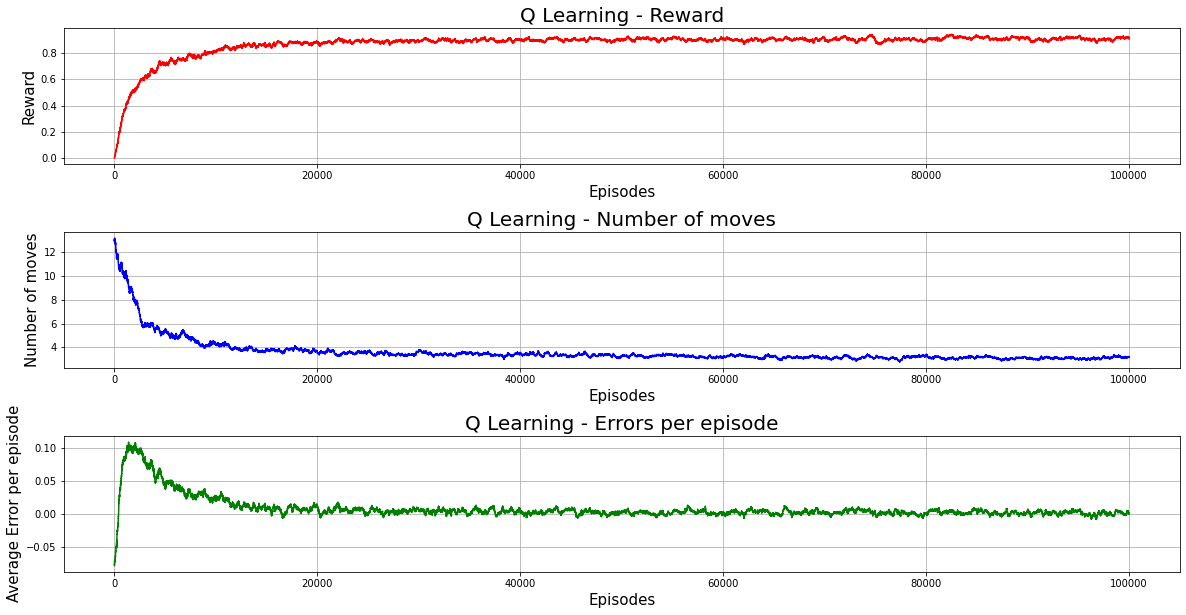

In [24]:
plot_trainingtime_against_R_and_moves_num(R_save_beta_change3,N_moves_save_beta_change3,errors_beta_change3,alpha)

## Deep SARSA
The above experiments are training with Q learning algorithms. In this case, we will try out SARSA algorithm as well. The neural network structure are excatly the same: 1 hidden layer and 200 neurons. There are 2 vrsions, one with ReLU activation function and one with leaky ReLU. and we change the β for SARSA as well

In [13]:
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE


#initialize the random values for epsilon greedy funtion

random_values=np.copy(random_values_initial) 


#initialize the weight

W1=np.copy(W1_initial)
W2=np.copy(W2_initial)

#initialize the biases

bias_W1 = np.zeros((n_hidden_layer,))
bias_W2 = np.zeros((n_output_layer,))

# SAVING VARIABLES
R_save_sarsa = np.zeros([N_episodes, 1])
N_moves_save_sarsa = np.zeros([N_episodes, 1])

# Keep track of the network inputs and average error per epoch
errors_sarsa = np.zeros([N_episodes,1])




for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    error = 0

    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME

    
    while Done==0:                           ## START THE EPISODE
        # Initialise the gradients for each step
        
        dW1 = np.zeros(W1.shape)
        dW2 = np.zeros(W2.shape)
        dbias_W1 = np.zeros(bias_W1.shape)
        dbias_W2 = np.zeros(bias_W2.shape)

        # Neural activation: input layer -> hidden layer
        h1 = np.dot(W1,X)+bias_W1
        # Apply the relu function
        x1 = np.maximum(0,h1)
        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,x1)+bias_W2
        # Apply the relu function
        x2 = np.maximum(0,h2)

        Qvalues = x2

        # Choose an action
        a, rand_value_updated = EpsilonGreedy_Policy(x2,epsilon_f,allowed_a,random_values,n)
        random_values=rand_value_updated
        #make a action
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a) 
        
        
        
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            # Compute the error signal: e=R+gamma*Q(S',a)-Q(S,A) where maxQ(S',a)=0
            e = R-Qvalues[a]
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a]=e
            error += e

            delta2 =mask_updated*np.heaviside(h2,0)

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = np.heaviside(h1,0) * np.dot(W2.T, delta2)
            

            
            dW1 = np.outer(delta1,X)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            
            R_save_sarsa[n] = np.copy(R)
            N_moves_save_sarsa[n] = np.copy(i)
            errors_sarsa[n] = error/i
            print("Episode ",n," Reward:" ,R," Number of steps:",i, " Average Error:",error/i)
            break
        
        # IF THE EPISODE IS NOT OVER...
        else: 
            # this Q(S',a) prediction process is similar to the above one
            h1_next = np.dot(W1,X_next)+bias_W1
            x1_next = np.maximum(0,h1_next)
            h2_next = np.dot(W2,x1_next)+bias_W2
            x2_next = np.maximum(0,h2_next)

            # SARSA use onpolicy strategy: EpsilonGreedy_Policy at S'
            a_next, rand_value_updated = EpsilonGreedy_Policy(x2_next,epsilon_f,allowed_a_next,random_values,n)
            random_values=rand_value_updated
            desired_output = R + gamma*x2_next[a_next]

            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A)
            predicted_Q = Qvalues[a]
            e = desired_output - predicted_Q
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a] = e
            error += e

            delta2 = np.heaviside(h2,0) * mask_updated

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = np.heaviside(h1,0) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1,X_next)
            dbias_W1 = delta1
            

            
            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            # record Reward and steps number
            i +=1      
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
print('Trained_Agent, Average reward:',np.mean(R_save_sarsa),'Number of steps: ',np.mean(N_moves_save_sarsa))

Streaming output truncated to the last 5000 lines.
Episode  95001  Reward: 1  Number of steps: 3  Average Error: 0.008819550174397506
Episode  95002  Reward: 1  Number of steps: 1  Average Error: 0.001866386682668697
Episode  95003  Reward: 1  Number of steps: 4  Average Error: 0.014714428812193397
Episode  95004  Reward: 1  Number of steps: 1  Average Error: -0.012933862537804819
Episode  95005  Reward: 1  Number of steps: 2  Average Error: 0.010191620154928027
Episode  95006  Reward: 1  Number of steps: 1  Average Error: 0.037123881972423556
Episode  95007  Reward: 1  Number of steps: 4  Average Error: 0.007890263037688167
Episode  95008  Reward: 1  Number of steps: 5  Average Error: -0.009136046569078715
Episode  95009  Reward: 1  Number of steps: 1  Average Error: 0.0017932881289877134
Episode  95010  Reward: 1  Number of steps: 2  Average Error: 0.024518981661330597
Episode  95011  Reward: 1  Number of steps: 5  Average Error: -0.009929881649456762
Episode  95012  Reward: 1  Numbe

In [14]:
def plot_trainingtime_against_R_and_moves_num_sarsa(R_save,N_moves_save,errors,alpha):
    ema_R = exponential_moving_average(R_save,alpha)
    ema_moves = exponential_moving_average(N_moves_save,alpha)
    ema_errors = exponential_moving_average(errors,alpha)
    
    
    fig,(ax1, ax2,ax3) = plt.subplots(3, figsize=(20, 10))
    fig.subplots_adjust(hspace=0.5)
    ax1.plot(ema_R,color='r')
    ax1.set_title('SARSA - Reward',fontsize = 20)
    ax1.set_ylabel('Reward',fontsize = 15)
    ax1.set_xlabel('Episodes',fontsize = 15)
    ax1.grid(True,which='major')
    
    ax2.plot(ema_moves,color='b')
    ax2.set_title('SARSA - Number of moves',fontsize = 20)
    ax2.set_ylabel('Number of moves',fontsize = 15)
    ax2.set_xlabel('Episodes',fontsize = 15)
    ax2.grid(True,which='major')

    ax3.plot(ema_errors,color='g')
    ax3.set_title('SARSA - Errors per episode',fontsize = 20)
    ax3.set_ylabel('Average Error per episode',fontsize = 15)
    ax3.set_xlabel('Episodes',fontsize = 15)
    ax3.grid(True,which='major')

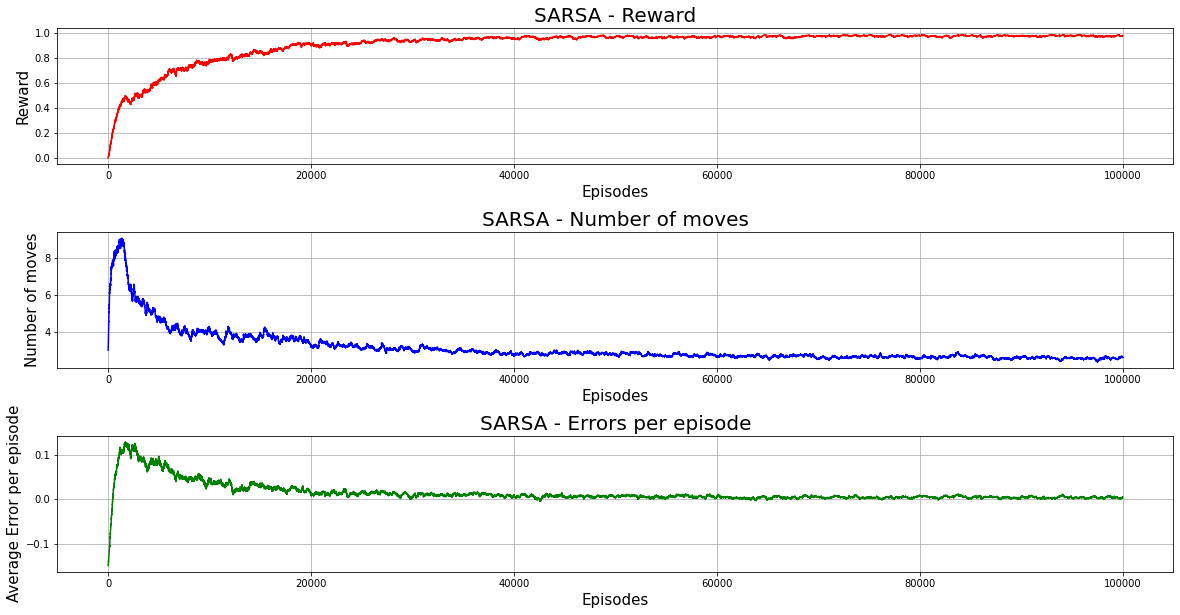

In [15]:
plot_trainingtime_against_R_and_moves_num_sarsa(R_save_sarsa,N_moves_save_sarsa,errors_sarsa,alpha)

### Experiment Deep SARSA with leaky Relu activation function

In [42]:
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE


#initialize the random values for epsilon greedy funtion

random_values=np.copy(random_values_initial) 


#initialize the weight

W1=np.copy(W1_initial)
W2=np.copy(W2_initial)

#initialize the biases

bias_W1 = np.zeros((n_hidden_layer,))
bias_W2 = np.zeros((n_output_layer,))

# SAVING VARIABLES
R_save_sarsa_leakyRelu = np.zeros([N_episodes, 1])
N_moves_save_sarsa_leakyRelu = np.zeros([N_episodes, 1])

# Keep track of the network inputs and average error per epoch
errors_sarsa_leakyRelu = np.zeros([N_episodes,1])



for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    error = 0
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME

    
    while Done==0:                           ## START THE EPISODE
        # Initialise the gradients for each step
        
        dW1 = np.zeros(W1.shape)
        dW2 = np.zeros(W2.shape)
        dbias_W1 = np.zeros(bias_W1.shape)
        dbias_W2 = np.zeros(bias_W2.shape)

        # Neural activation: input layer -> hidden layer
        h1 = np.dot(W1,X)+bias_W1
        # Apply the leaky relu function
        x1 = np.maximum(0,h1)+negative_slope*np.minimum(0,h1)
        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,x1)+bias_W2
        # Apply the leaky relu function
        x2 = np.maximum(0,h2)+negative_slope*np.minimum(0,h2)

        Qvalues = x2

        # Choose an action
        a, rand_value_updated = EpsilonGreedy_Policy(x2,epsilon_f,allowed_a,random_values,n)
        random_values=rand_value_updated
        #make a action
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a) 
        
        
        
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            # Compute the error signal: e=R+gamma*Q(S',a)-Q(S,A) where maxQ(S',a)=0
            e = R-Qvalues[a]
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a]=e
            
            error += e

            delta2 =mask_updated*leaky_relu_derivative(h2)

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = leaky_relu_derivative(h1) * np.dot(W2.T, delta2)
            

            
            dW1 = np.outer(delta1,X)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            
            R_save_sarsa_leakyRelu[n] = np.copy(R)
            N_moves_save_sarsa_leakyRelu[n] = np.copy(i)
            errors_sarsa_leakyRelu[n] = error/i
            print("Episode ",n," Reward:" ,R," Number of steps:",i, " Average Error:",error/i)
            break
        
        # IF THE EPISODE IS NOT OVER...
        else: 
            # this Q(S',a) prediction process is similar to the above one
            h1_next = np.dot(W1,X_next)+bias_W1
            x1_next = np.maximum(0,h1_next)+negative_slope*np.minimum(0,h1_next)
            h2_next = np.dot(W2,x1_next)+bias_W2
            x2_next = np.maximum(0,h2_next)+negative_slope*np.minimum(0,h2_next)

            # SARSA use onpolicy strategy: EpsilonGreedy_Policy at S'
            a_next, rand_value_updated = EpsilonGreedy_Policy(x2_next,epsilon_f,allowed_a_next,random_values,n)
            random_values=rand_value_updated
            desired_output = R + gamma*x2_next[a_next]

            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A)
            predicted_Q = Qvalues[a]
            e = desired_output - predicted_Q
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a] = e
            error += e

            delta2 = leaky_relu_derivative(h2) * mask_updated

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = leaky_relu_derivative(h1) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1,X_next)
            dbias_W1 = delta1
            

            
            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            # record Reward and steps number
            i +=1      
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
print('Trained_Agent, Average reward:',np.mean(R_save_sarsa_leakyRelu),'Number of steps: ',np.mean(N_moves_save_sarsa_leakyRelu))

Streaming output truncated to the last 5000 lines.
Episode  95001  Reward: 1  Number of steps: 2  Average Error: 2146.599002119783
Episode  95002  Reward: 1  Number of steps: 3  Average Error: 1431.0743600593885
Episode  95003  Reward: 1  Number of steps: 1  Average Error: 4293.224803254489
Episode  95004  Reward: 1  Number of steps: 2  Average Error: 2146.632471087079
Episode  95005  Reward: 1  Number of steps: 4  Average Error: 1073.2653595588702
Episode  95006  Reward: 1  Number of steps: 2  Average Error: 2146.5344954224834
Episode  95007  Reward: 1  Number of steps: 2  Average Error: 2146.56611708826
Episode  95008  Reward: 1  Number of steps: 3  Average Error: 1430.931827967398
Episode  95009  Reward: 1  Number of steps: 1  Average Error: 4292.780040532818
Episode  95010  Reward: 1  Number of steps: 3  Average Error: 1430.9534503104453
Episode  95011  Reward: 1  Number of steps: 2  Average Error: 2146.4378980889855
Episode  95012  Reward: 1  Number of steps: 2  Average Error: 214

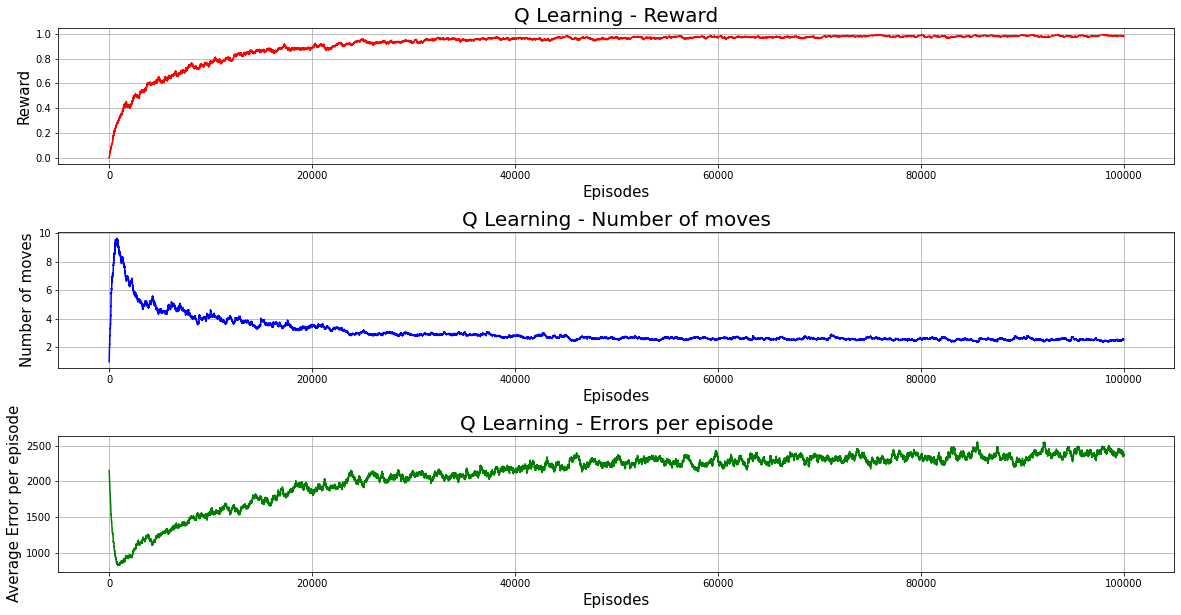

In [43]:
plot_trainingtime_against_R_and_moves_num_sarsa(R_save_sarsa_leakyRelu, N_moves_save_sarsa_leakyRelu, errors_sarsa_leakyRelu, alpha)

### Experiment Deep SARSA with Beta change

In [16]:
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0            # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE


#initialize the random values for epsilon greedy funtion

random_values=np.copy(random_values_initial) 


#initialize the weight

W1=np.copy(W1_initial)
W2=np.copy(W2_initial)

#initialize the biases

bias_W1 = np.zeros((n_hidden_layer,))
bias_W2 = np.zeros((n_output_layer,))

# SAVING VARIABLES
R_save_sarsa_beta = np.zeros([N_episodes, 1])
N_moves_save_sarsa_beta = np.zeros([N_episodes, 1])

# Keep track of the network inputs and average error per epoch
errors_sarsa_beta = np.zeros([N_episodes,1])




for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    error = 0
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME

    
    while Done==0:                           ## START THE EPISODE
        # Initialise the gradients for each step
        
        dW1 = np.zeros(W1.shape)
        dW2 = np.zeros(W2.shape)
        dbias_W1 = np.zeros(bias_W1.shape)
        dbias_W2 = np.zeros(bias_W2.shape)

        # Neural activation: input layer -> hidden layer
        h1 = np.dot(W1,X)+bias_W1
        # Apply the relu function
        x1 = np.maximum(0,h1)
        # Neural activation: hidden layer -> output layer
        h2 = np.dot(W2,x1)+bias_W2
        # Apply the relu function
        x2 = np.maximum(0,h2)

        Qvalues = x2

        # Choose an action
        a, rand_value_updated = EpsilonGreedy_Policy(x2,epsilon_f,allowed_a,random_values,n)
        random_values=rand_value_updated
        #make a action
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a) 
        
        
        
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            # Compute the error signal: e=R+gamma*Q(S',a)-Q(S,A) where maxQ(S',a)=0
            e = R-Qvalues[a]
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a]=e
            error += e

            delta2 =mask_updated*np.heaviside(h2,0)

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = np.heaviside(h1,0) * np.dot(W2.T, delta2)
            

            
            dW1 = np.outer(delta1,X)
            dbias_W1 = delta1

            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            
            R_save_sarsa_beta[n] = np.copy(R)
            N_moves_save_sarsa_beta[n] = np.copy(i)
            errors_sarsa_beta[n] = error/i
            print("Episode ",n," Reward:" ,R," Number of steps:",i, " Average Error:",error/i)
            break
        
        # IF THE EPISODE IS NOT OVER...
        else: 
            # this Q(S',a) prediction process is similar to the above one
            h1_next = np.dot(W1,X_next)+bias_W1
            x1_next = np.maximum(0,h1_next)
            h2_next = np.dot(W2,x1_next)+bias_W2
            x2_next = np.maximum(0,h2_next)

            # SARSA use onpolicy strategy: EpsilonGreedy_Policy at S'
            a_next, rand_value_updated = EpsilonGreedy_Policy(x2_next,epsilon_f,allowed_a_next,random_values,n)
            random_values=rand_value_updated
            desired_output = R + gamma*x2_next[a_next]

            # Compute the error signal: e=R+gamma*maxQ(S',a)-Q(S,A)
            predicted_Q = Qvalues[a]
            e = desired_output - predicted_Q
            # create a mask, let mask[a]-e
            mask_updated = np.copy(mask)
            mask_updated[a] = e
            error += e

            delta2 = np.heaviside(h2,0) * mask_updated

            dW2 = np.outer(delta2, x1)
            dbias_W2 = delta2

            # Backpropagation: hidden layer -> input layer
            delta1 = np.heaviside(h1,0) * np.dot(W2.T, delta2)
            dW1 = np.outer(delta1,X_next)
            dbias_W1 = delta1
            

            
            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2
            
            # record Reward and steps number
            i +=1      
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
print('Trained_Agent, Average reward:',np.mean(R_save_sarsa_beta),'Number of steps: ',np.mean(N_moves_save_sarsa_beta))

Streaming output truncated to the last 5000 lines.
Episode  95001  Reward: 1  Number of steps: 1  Average Error: -0.014463174797145761
Episode  95002  Reward: 1  Number of steps: 4  Average Error: -0.02235276632710577
Episode  95003  Reward: 1  Number of steps: 2  Average Error: 0.31983588618597725
Episode  95004  Reward: 1  Number of steps: 6  Average Error: -0.0718247893462768
Episode  95005  Reward: 1  Number of steps: 1  Average Error: 0.0470552604006923
Episode  95006  Reward: 1  Number of steps: 1  Average Error: -0.005354155414516448
Episode  95007  Reward: 1  Number of steps: 3  Average Error: 0.0013747627974198446
Episode  95008  Reward: 0  Number of steps: 1  Average Error: -0.12082375941003135
Episode  95009  Reward: 1  Number of steps: 1  Average Error: 0.08333771719567729
Episode  95010  Reward: 1  Number of steps: 2  Average Error: -0.1584420101827025
Episode  95011  Reward: 1  Number of steps: 1  Average Error: 0.053898852959045174
Episode  95012  Reward: 0  Number of st

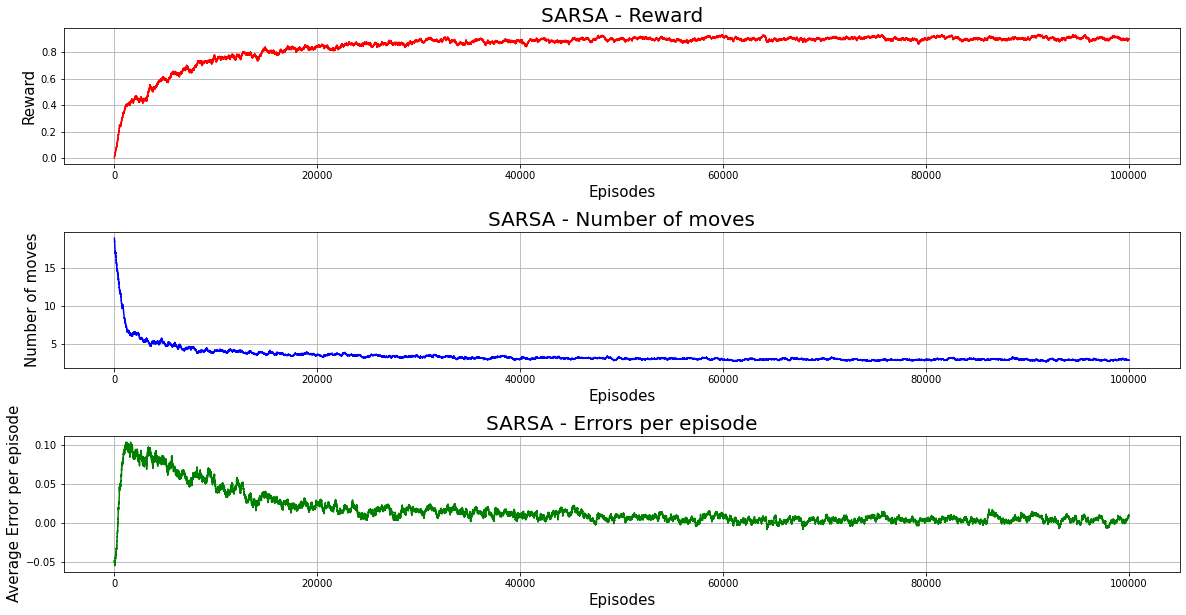

In [17]:
plot_trainingtime_against_R_and_moves_num_sarsa(R_save_sarsa_beta,N_moves_save_sarsa_beta,errors_sarsa_beta,alpha)

## Comparison

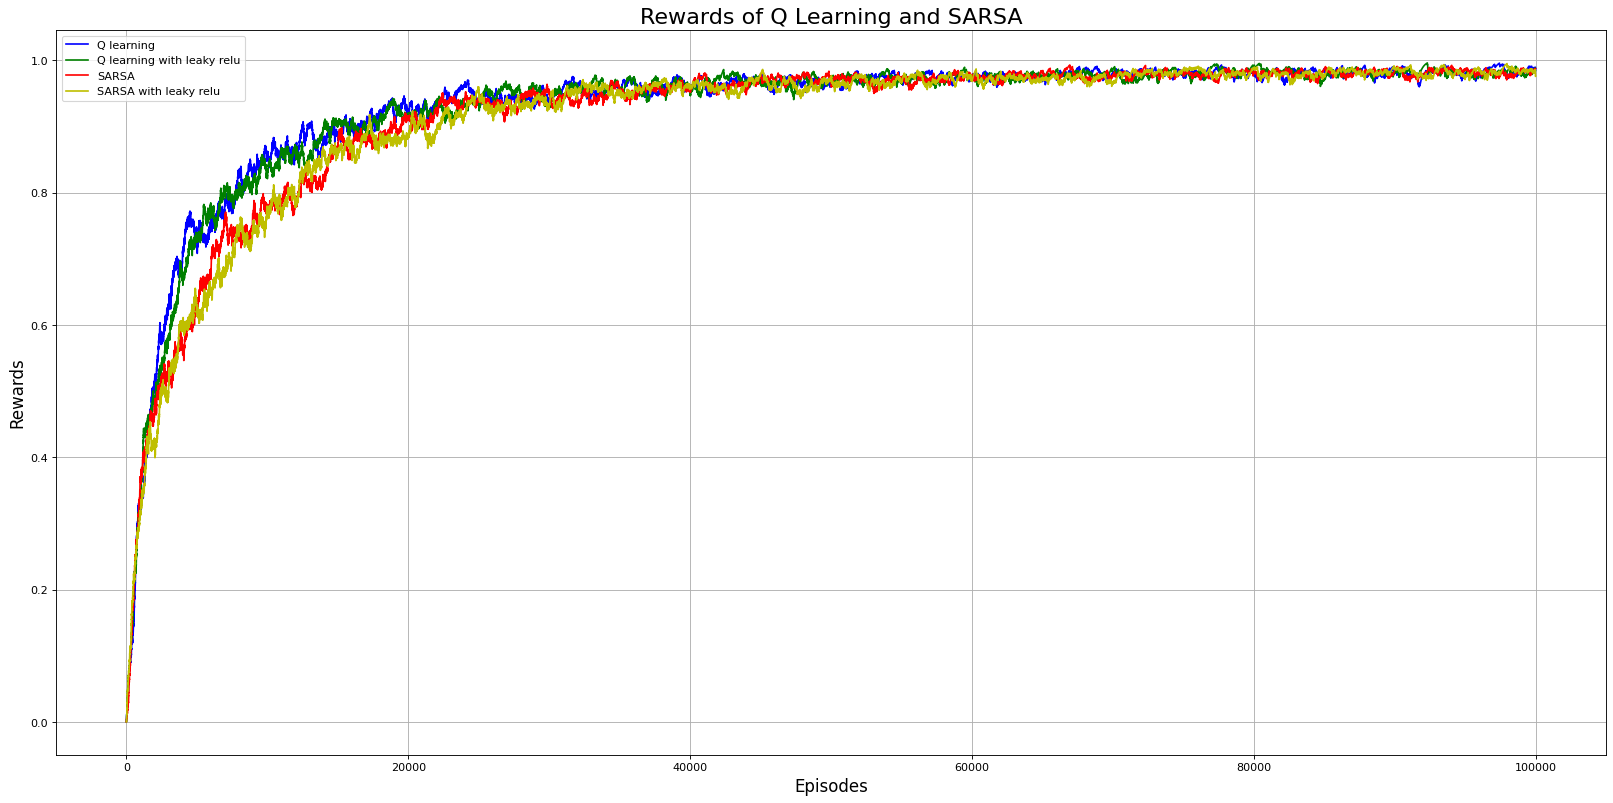

In [47]:
ema_dqn = exponential_moving_average(R_save,alpha)
ema_dqn_leaky = exponential_moving_average(R_save_wtih_leakyRelu,alpha)
ema_deep_sarsa = exponential_moving_average(R_save_sarsa,alpha)
ema_deep_sarsa_leaky =  exponential_moving_average(R_save_sarsa_leakyRelu,alpha)

plt.figure(figsize=(25, 12), dpi=80)
    
plt.plot(ema_dqn,color = "b",label='Q learning')
plt.plot(ema_dqn_leaky,color = "g",label='Q learning with leaky relu')
plt.plot(ema_deep_sarsa,color = "r",label='SARSA')
plt.plot(ema_deep_sarsa_leaky,color = "y",label='SARSA with leaky relu')
plt.legend()

plt.title('Rewards of Q Learning and SARSA',fontsize = 20)
plt.ylabel('Rewards',fontsize = 15)
plt.xlabel('Episodes',fontsize = 15)
plt.grid(True,which='major')


The graph shows that the two Q-learning network converges
quicker than the SARSAs. This observation is consistent with
the former analysis from theoretical perspective as Q-learn
learns toward the option strategy(to perform checkmate) while
SARSA only learns the strategy of ”performing checkmate
under a 1-ϵ probability”. In the early training episode, this
difference is obvious but in the later episode, as the β decays
the ϵ, ϵ becomes smaller so this difference will disappear.

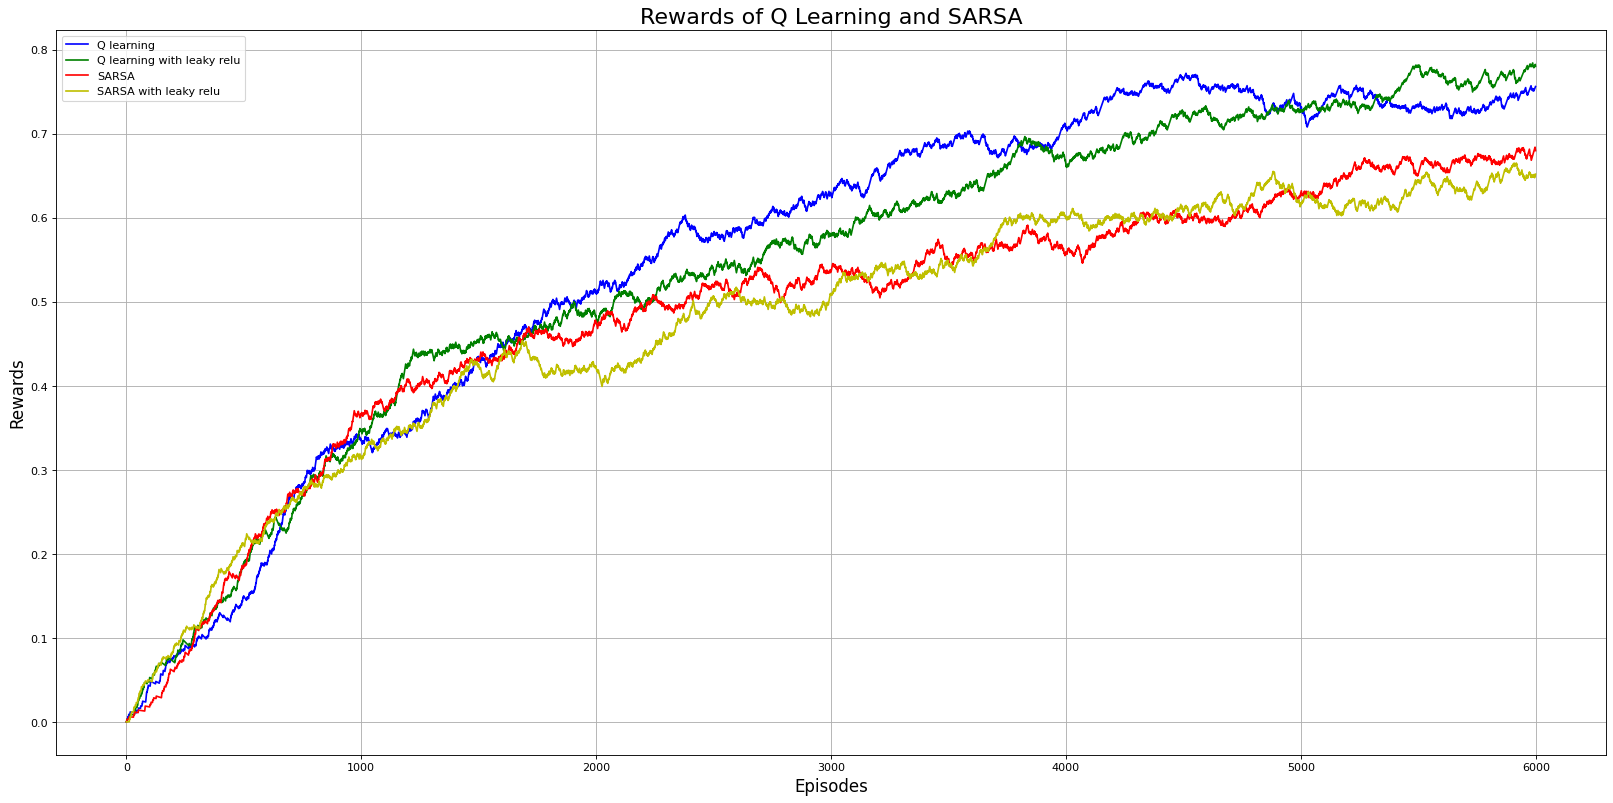

In [46]:
ema_dqn = exponential_moving_average(R_save,alpha)
ema_dqn_leaky = exponential_moving_average(R_save_wtih_leakyRelu,alpha)
ema_deep_sarsa = exponential_moving_average(R_save_sarsa,alpha)
ema_deep_sarsa_leaky =  exponential_moving_average(R_save_sarsa_leakyRelu,alpha)

plt.figure(figsize=(25, 12), dpi=80)
    
plt.plot(ema_dqn[:6000],color = "b",label='Q learning')
plt.plot(ema_dqn_leaky[:6000],color = "g",label='Q learning with leaky relu')
plt.plot(ema_deep_sarsa[:6000],color = "r",label='SARSA')
plt.plot(ema_deep_sarsa_leaky[:6000],color = "y",label='SARSA with leaky relu')
plt.legend()

plt.title('Rewards of Q Learning and SARSA',fontsize = 20)
plt.ylabel('Rewards',fontsize = 15)
plt.xlabel('Episodes',fontsize = 15)
plt.grid(True,which='major')


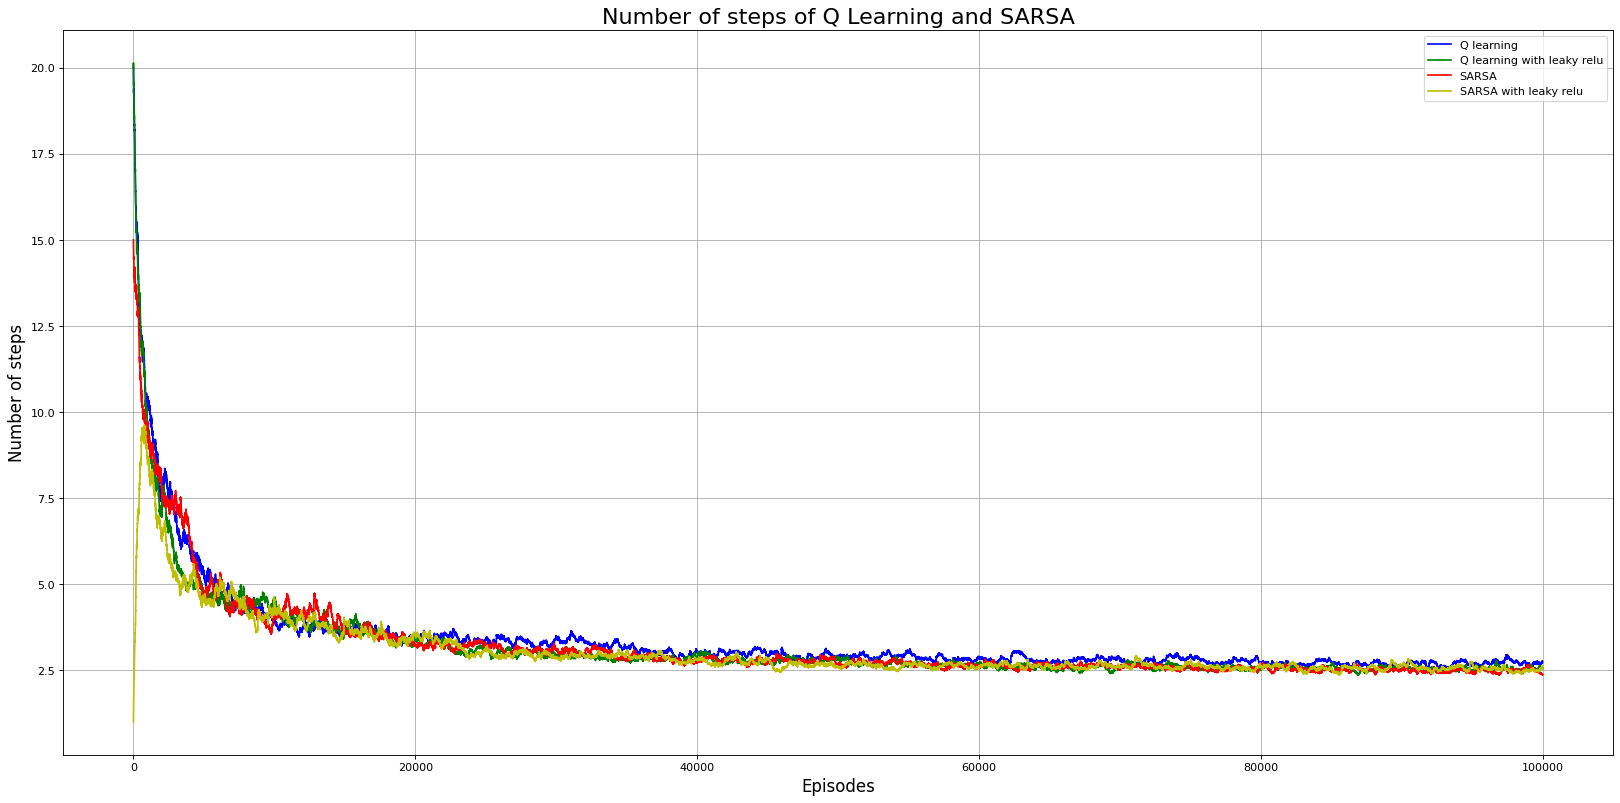

In [48]:
ema_dqn_move = exponential_moving_average(N_moves_save,alpha)
ema_dqn_leaky_move = exponential_moving_average(N_moves_save_wtih_leakyRelu,alpha)
ema_deep_sarsa_move = exponential_moving_average(N_moves_save_sarsa,alpha)
ema_deep_sarsa_leaky_move =  exponential_moving_average(N_moves_save_sarsa_leakyRelu,alpha)

plt.figure(figsize=(25, 12), dpi=80)
    
plt.plot(ema_dqn_move,color = "b",label='Q learning')
plt.plot(ema_dqn_leaky_move,color = "g",label='Q learning with leaky relu')
plt.plot(ema_deep_sarsa_move,color = "r",label='SARSA')
plt.plot(ema_deep_sarsa_leaky_move,color = "y",label='SARSA with leaky relu')
plt.legend()

plt.title('Number of steps of Q Learning and SARSA',fontsize = 20)
plt.ylabel('Number of steps',fontsize = 15)
plt.xlabel('Episodes',fontsize = 15)
plt.grid(True,which='major')

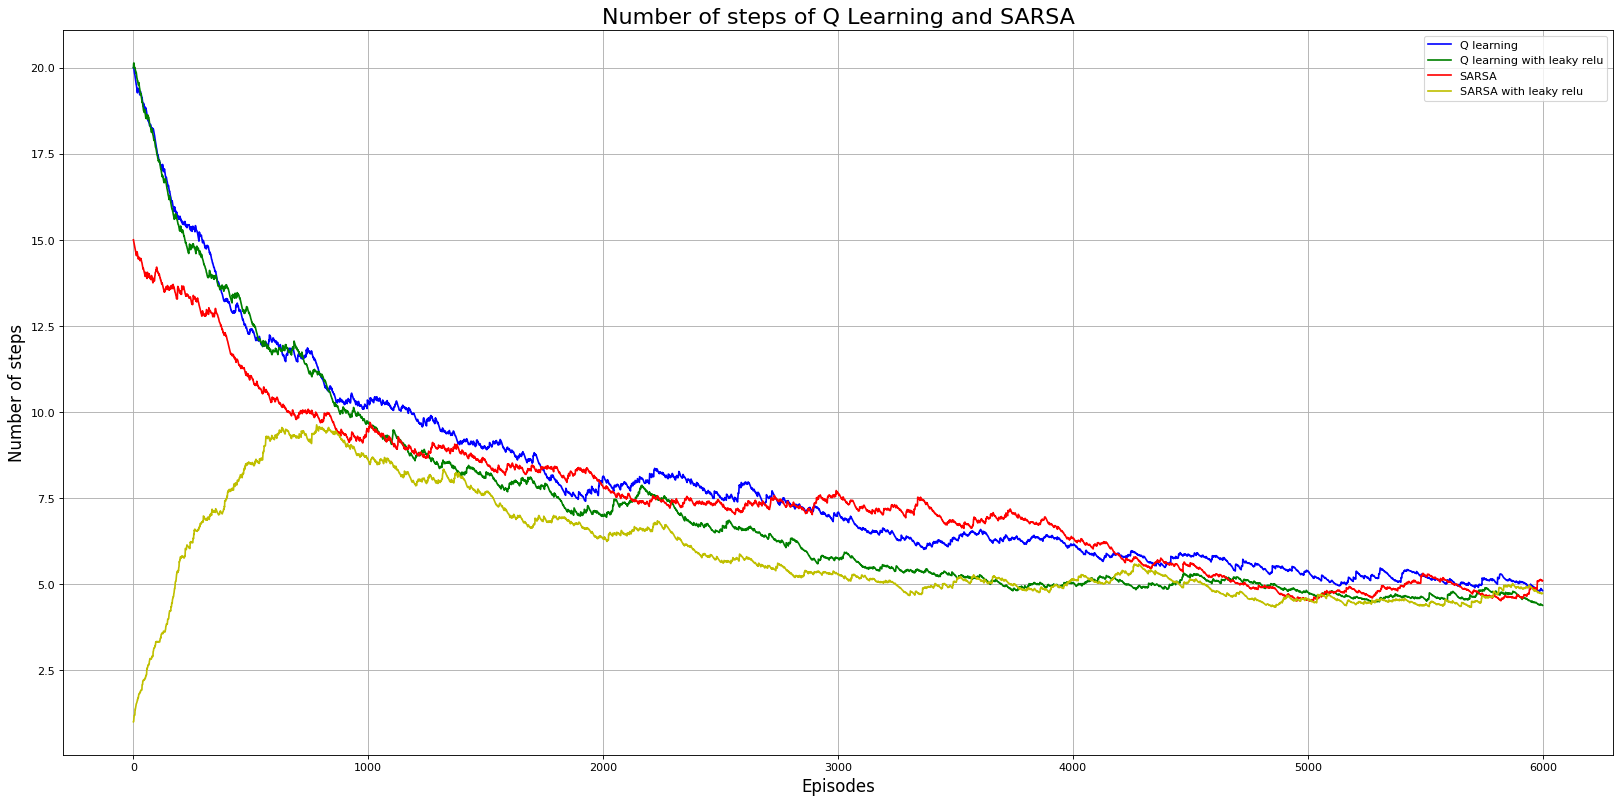

In [49]:
ema_dqn_move = exponential_moving_average(N_moves_save,alpha)
ema_dqn_leaky_move = exponential_moving_average(N_moves_save_wtih_leakyRelu,alpha)
ema_deep_sarsa_move = exponential_moving_average(N_moves_save_sarsa,alpha)
ema_deep_sarsa_leaky_move =  exponential_moving_average(N_moves_save_sarsa_leakyRelu,alpha)

plt.figure(figsize=(25, 12), dpi=80)
    
plt.plot(ema_dqn_move[:6000],color = "b",label='Q learning')
plt.plot(ema_dqn_leaky_move[:6000],color = "g",label='Q learning with leaky relu')
plt.plot(ema_deep_sarsa_move[:6000],color = "r",label='SARSA')
plt.plot(ema_deep_sarsa_leaky_move[:6000],color = "y",label='SARSA with leaky relu')
plt.legend()

plt.title('Number of steps of Q Learning and SARSA',fontsize = 20)
plt.ylabel('Number of steps',fontsize = 15)
plt.xlabel('Episodes',fontsize = 15)
plt.grid(True,which='major')

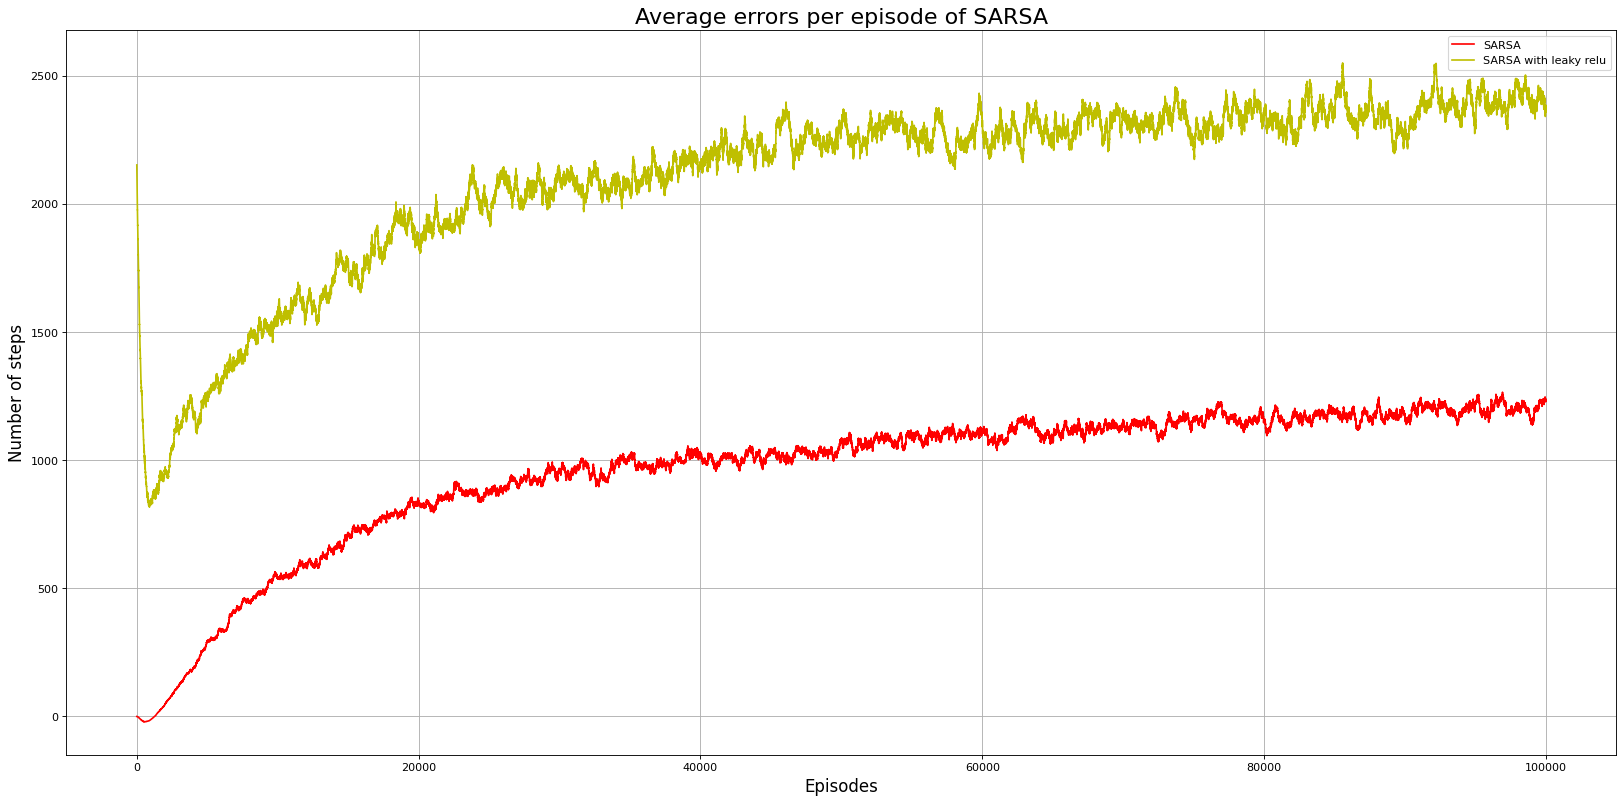

In [73]:

ema_deep_sarsa_errors = exponential_moving_average(errors_sarsa,alpha)
ema_deep_sarsa_leaky_errors =  exponential_moving_average(errors_sarsa_leakyRelu,alpha)

plt.figure(figsize=(25, 12), dpi=80)
    

plt.plot(ema_deep_sarsa_errors,color = "r",label='SARSA')
plt.plot(ema_deep_sarsa_leaky_errors,color = "y",label='SARSA with leaky relu')
plt.legend()

plt.title('Average error per episode of SARSA',fontsize = 20)
plt.ylabel('Average error per episode',fontsize = 15)
plt.xlabel('Episodes',fontsize = 15)
plt.grid(True,which='major')

Now lets compare the Deep Q network with different $\gamma$ and $\beta$

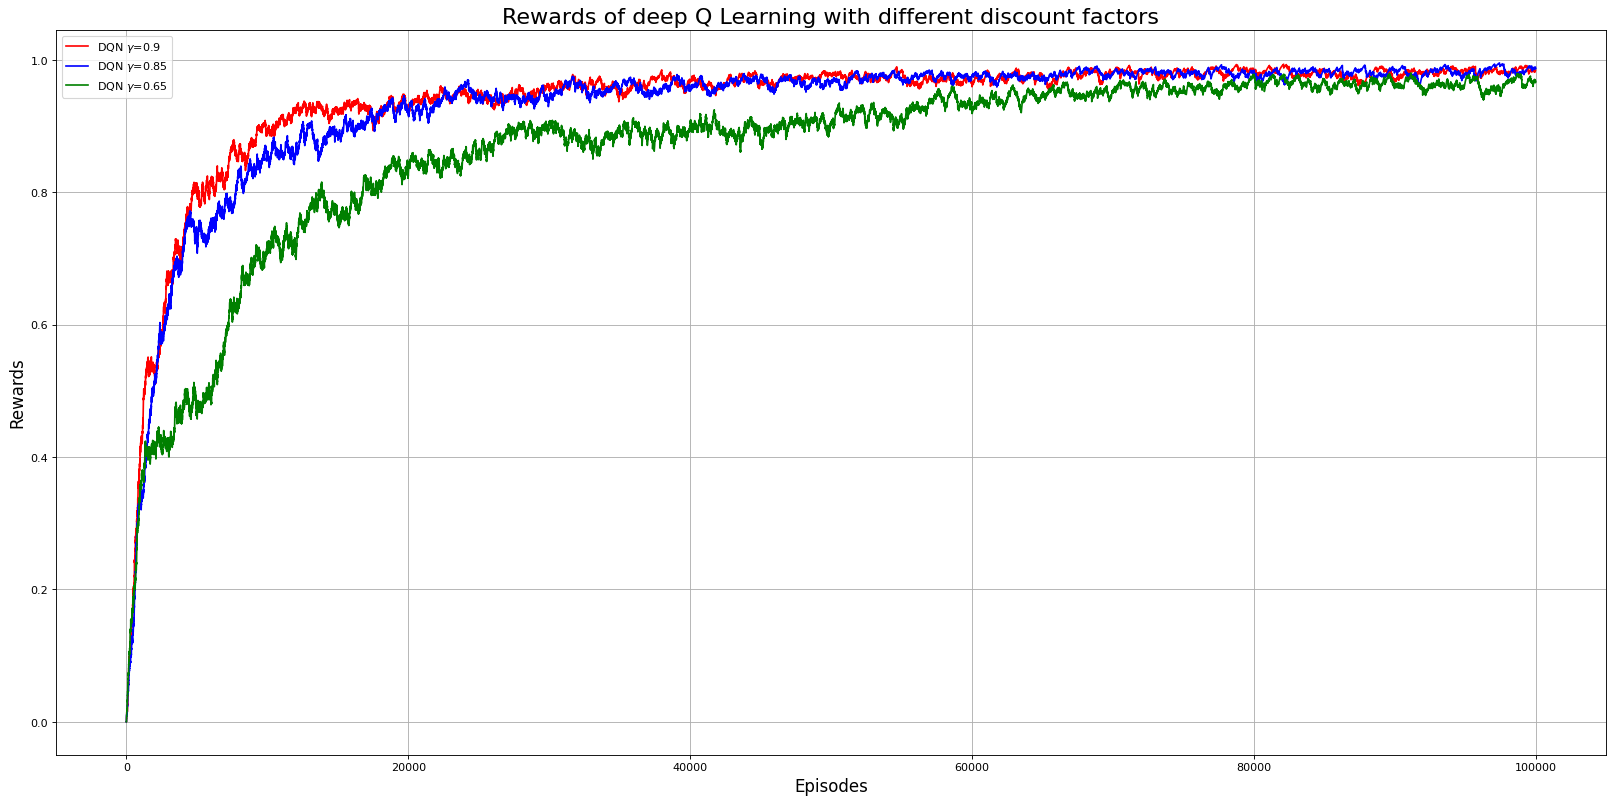

In [51]:
ema_dqn = exponential_moving_average(R_save,alpha)
ema_dqn_gamma1 = exponential_moving_average(R_save_gamma_change1,alpha)
ema_dqn_gamma2 = exponential_moving_average(R_save_gamma_change2,alpha)

plt.figure(figsize=(25, 12), dpi=80)

plt.plot(ema_dqn_gamma1,color = "r",label='DQN $γ$=0.9')
plt.plot(ema_dqn,color = "b",label='DQN $γ$=0.85')
plt.plot(ema_dqn_gamma2,color = "g",label='DQN $γ$=0.65')

plt.legend()

plt.title('Rewards of deep Q Learning with different discount factors',fontsize = 20)
plt.ylabel('Rewards',fontsize = 15)
plt.xlabel('Episodes',fontsize = 15)
plt.grid(True,which='major')




As we can see, the result is consistent with our theory. As
γ increases, the reward of checkmate in the future will have a
larger effect on training, so the reward converges to 1 quicker.
Similarly effects should be able to be observed in case of
SARSA.


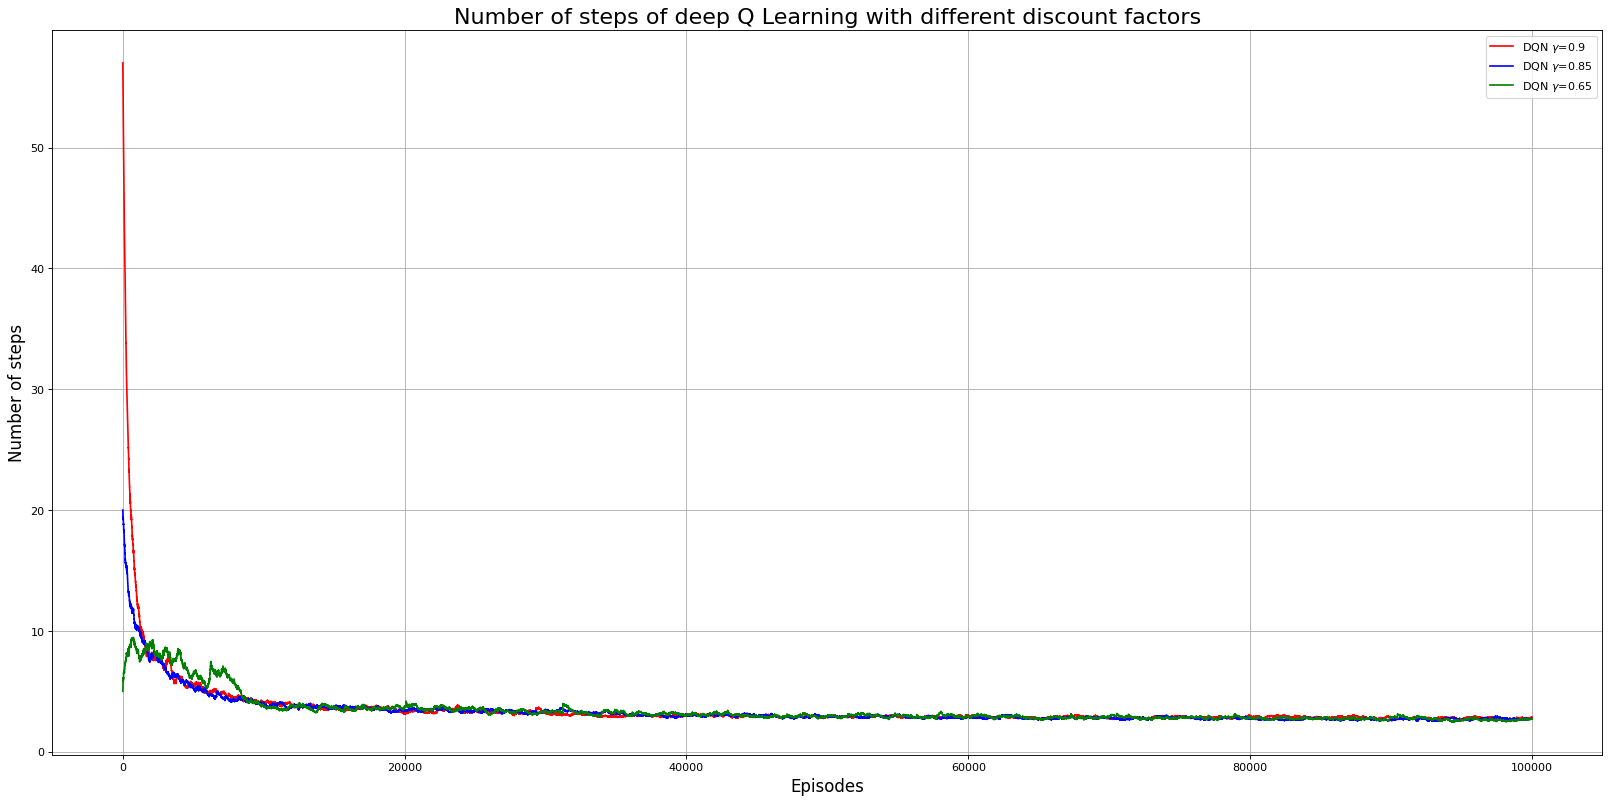

In [54]:
ema_dqn_move = exponential_moving_average(N_moves_save,alpha)
ema_dqn_move_gamma1 = exponential_moving_average(N_moves_save_gamma_change1,alpha)
ema_dqn_move_gamma2 = exponential_moving_average(N_moves_save_gamma_change2,alpha)

plt.figure(figsize=(25, 12), dpi=80)

plt.plot(ema_dqn_move_gamma1 ,color = "r",label='DQN $γ$=0.9')  
plt.plot(ema_dqn_move,color = "b",label='DQN $γ$=0.85')
plt.plot(ema_dqn_move_gamma2 ,color = "g",label='DQN $γ$=0.65')
plt.legend()

plt.title('Number of steps of deep Q Learning with different discount factors',fontsize = 20)
plt.ylabel('Number of steps',fontsize = 15)
plt.xlabel('Episodes',fontsize = 15)
plt.grid(True,which='major')

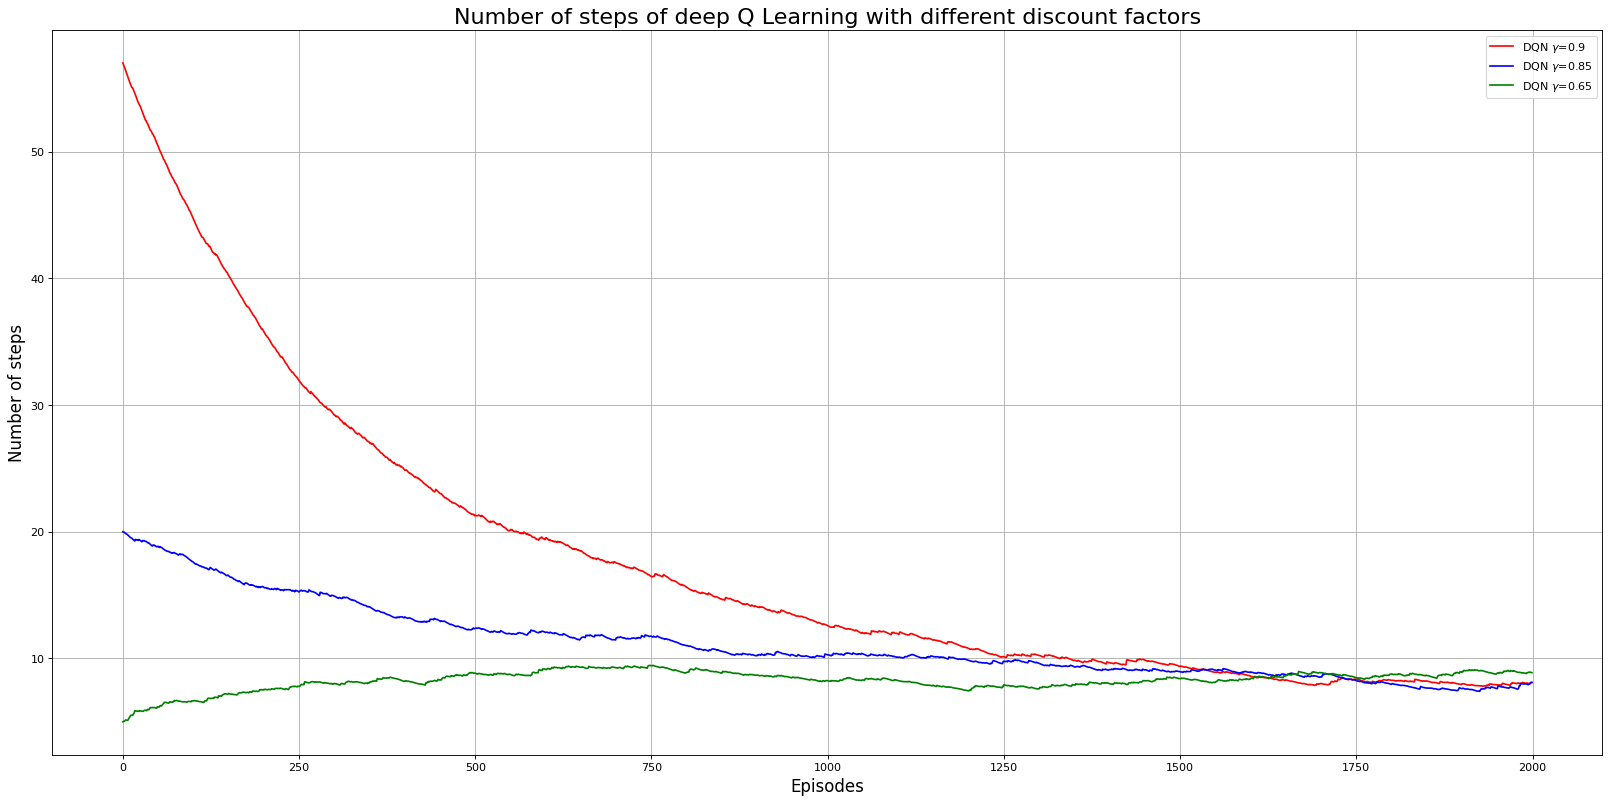

In [55]:
ema_dqn_move = exponential_moving_average(N_moves_save,alpha)
ema_dqn_move_gamma1 = exponential_moving_average(N_moves_save_gamma_change1,alpha)
ema_dqn_move_gamma2 = exponential_moving_average(N_moves_save_gamma_change2,alpha)

plt.figure(figsize=(25, 12), dpi=80)

plt.plot(ema_dqn_move_gamma1[:2000] ,color = "r",label='DQN $γ$=0.9')  
plt.plot(ema_dqn_move[:2000],color = "b",label='DQN $γ$=0.85')
plt.plot(ema_dqn_move_gamma2[:2000] ,color = "g",label='DQN $γ$=0.65')
plt.legend()

plt.title('Number of steps of deep Q Learning with different discount factors',fontsize = 20)
plt.ylabel('Number of steps',fontsize = 15)
plt.xlabel('Episodes',fontsize = 15)
plt.grid(True,which='major')

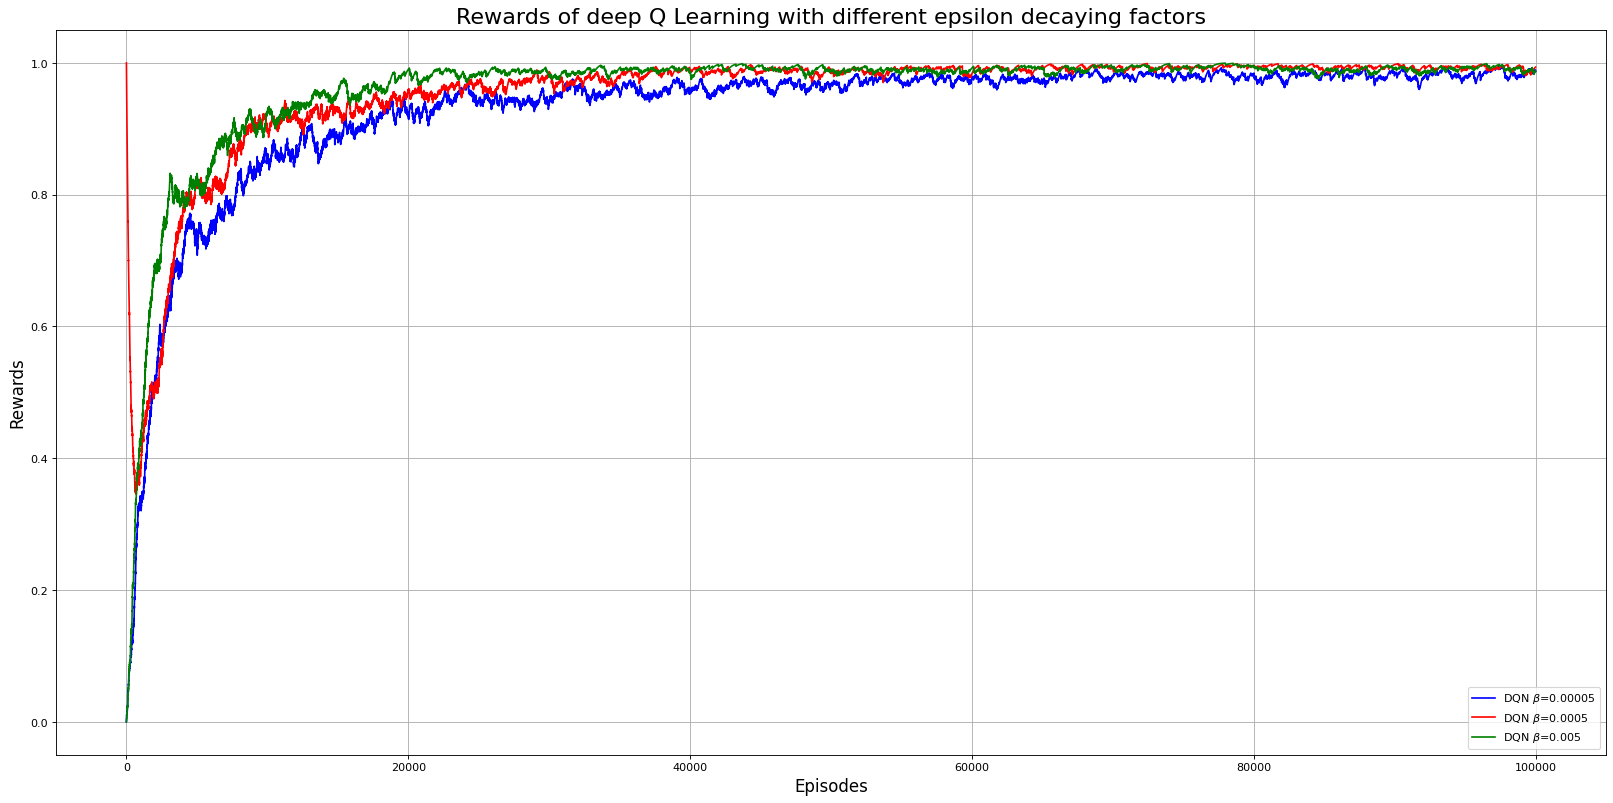

In [57]:
ema_dqn = exponential_moving_average(R_save,alpha)
ema_dqn_beta1 = exponential_moving_average(R_save_beta_change1,alpha)
ema_dqn_beta2 = exponential_moving_average(R_save_beta_change2,alpha)

plt.figure(figsize=(25, 12), dpi=80)
    
plt.plot(ema_dqn,color = "b",label='DQN $β$=0.00005')
plt.plot(ema_dqn_beta1,color = "r",label='DQN $β$=0.0005')
plt.plot(ema_dqn_beta2,color = "g",label='DQN $β$=0.005')

plt.legend()

plt.title('Rewards of deep Q Learning with different epsilon decaying factors',fontsize = 20)
plt.ylabel('Rewards',fontsize = 15)
plt.xlabel('Episodes',fontsize = 15)
plt.grid(True,which='major')

A experiment with 3 different βs shows that the higher the
β, the earlier rewards converges to the optimal level. It is worth
noticing that these three βs are all in a acceptable range for
this environment case. If the environment is more complicated
and the β is large enough to make the ϵ decayed too fast, the
agent will employ exploitation without enough exploration of
the environment. A early exploitation will result in low average
rewards


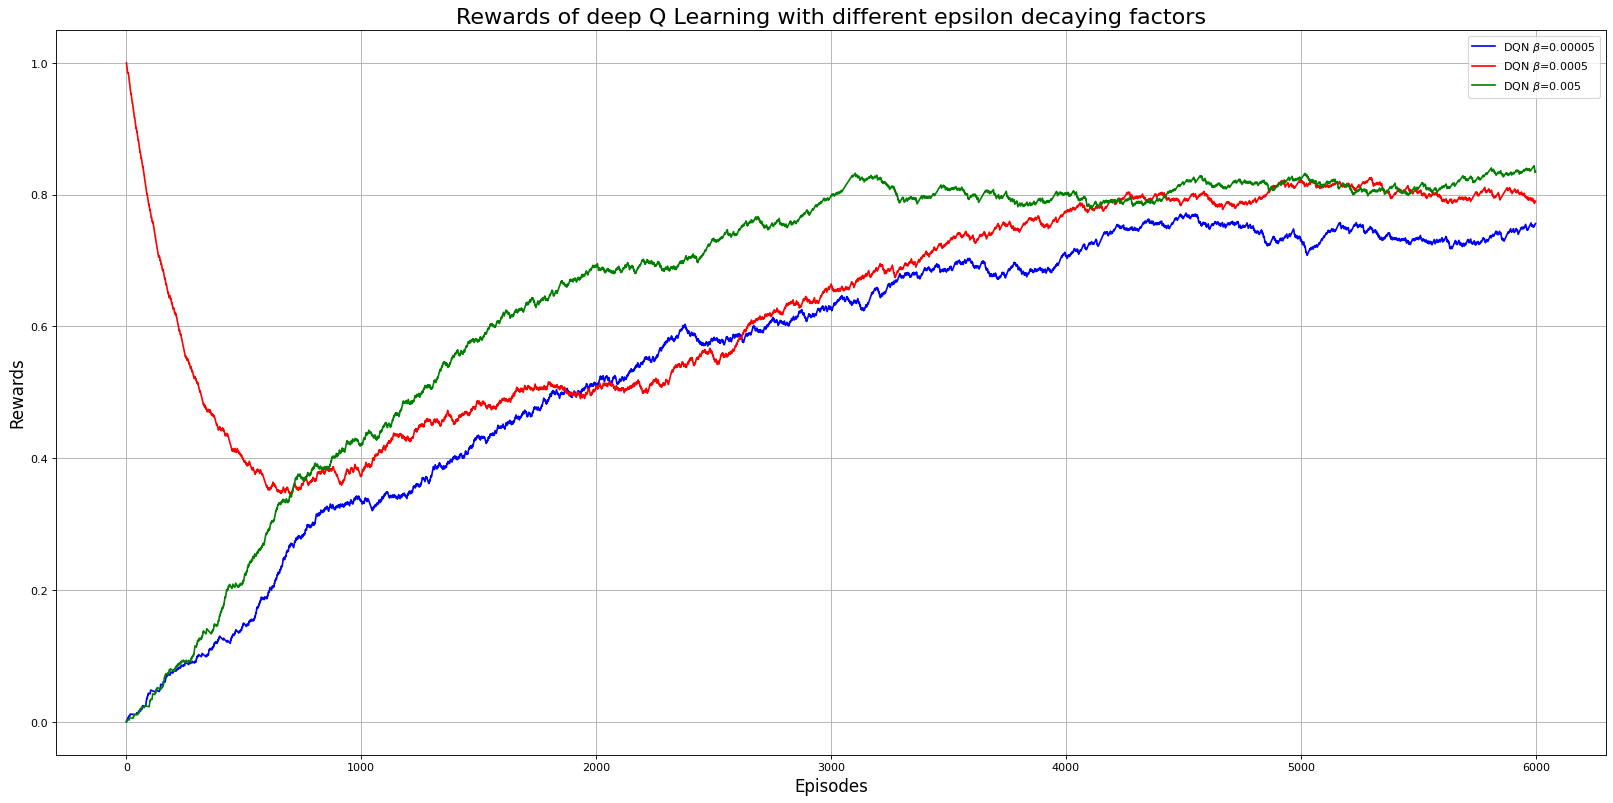

In [60]:
ema_dqn = exponential_moving_average(R_save,alpha)
ema_dqn_beta1 = exponential_moving_average(R_save_beta_change1,alpha)
ema_dqn_beta2 = exponential_moving_average(R_save_beta_change2,alpha)

plt.figure(figsize=(25, 12), dpi=80)
    
plt.plot(ema_dqn[:6000],color = "b",label='DQN $β$=0.00005')
plt.plot(ema_dqn_beta1[:6000],color = "r",label='DQN $β$=0.0005')
plt.plot(ema_dqn_beta2[:6000],color = "g",label='DQN $β$=0.005')

plt.legend()

plt.title('Rewards of deep Q Learning with different epsilon decaying factors',fontsize = 20)
plt.ylabel('Rewards',fontsize = 15)
plt.xlabel('Episodes',fontsize = 15)
plt.grid(True,which='major')

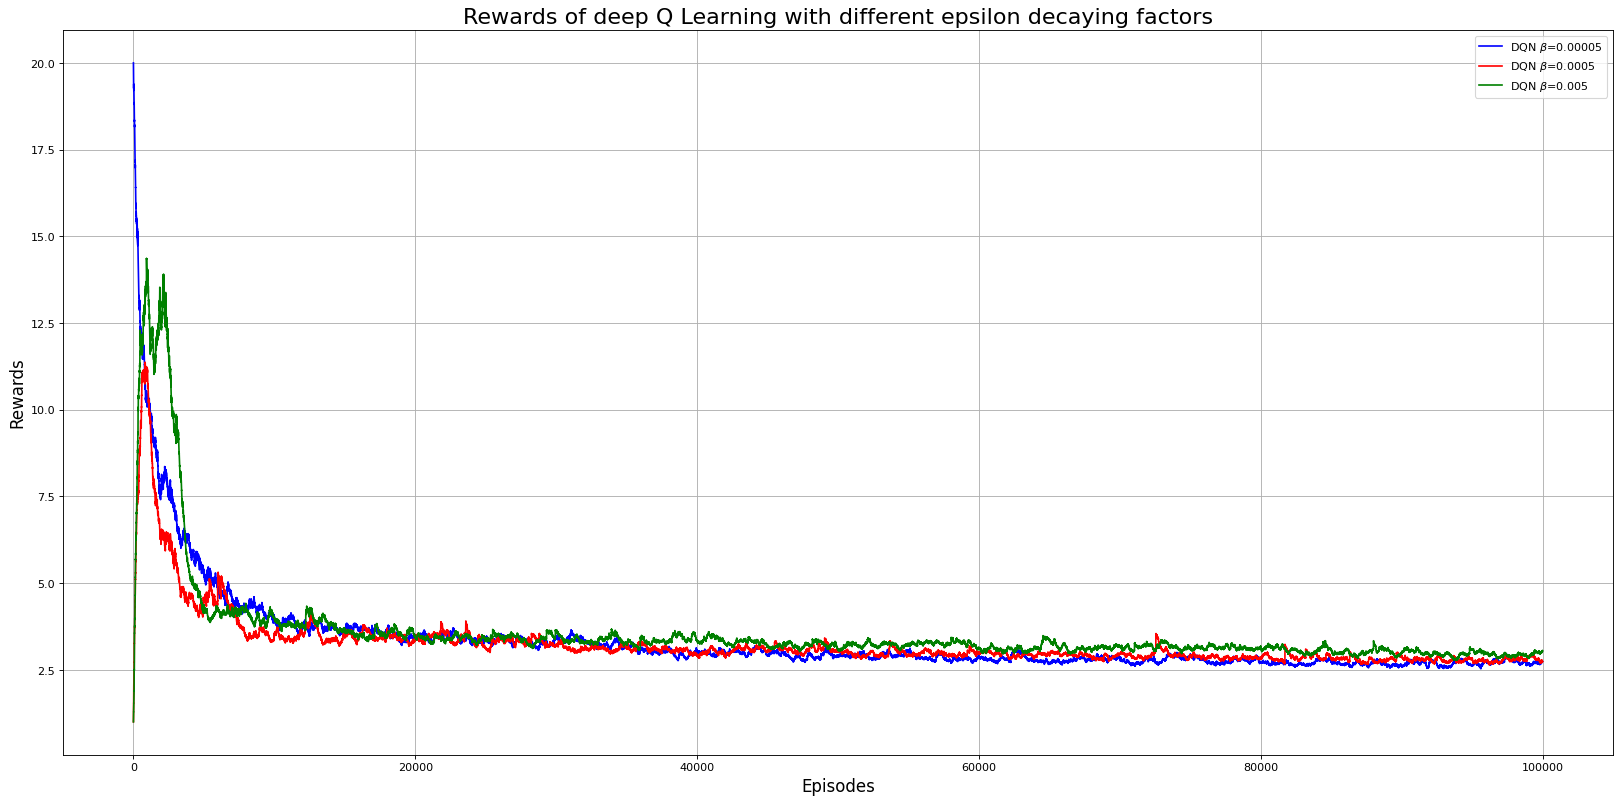

In [63]:
ema_dqn_move = exponential_moving_average(N_moves_save,alpha)
ema_dqn_move_beta1 = exponential_moving_average(N_moves_save_beta_change1,alpha)
ema_dqn_move_beta2 = exponential_moving_average(N_moves_save_beta_change2,alpha)

plt.figure(figsize=(25, 12), dpi=80)
    
plt.plot(ema_dqn_move,color = "b",label='DQN $β$=0.00005')
plt.plot(ema_dqn_move_beta1,color = "r",label='DQN $β$=0.0005')
plt.plot(ema_dqn_move_beta2,color = "g",label='DQN $β$=0.005')

plt.legend()

plt.title('Rewards of deep Q Learning with different epsilon decaying factors',fontsize = 20)
plt.ylabel('Rewards',fontsize = 15)
plt.xlabel('Episodes',fontsize = 15)
plt.grid(True,which='major')

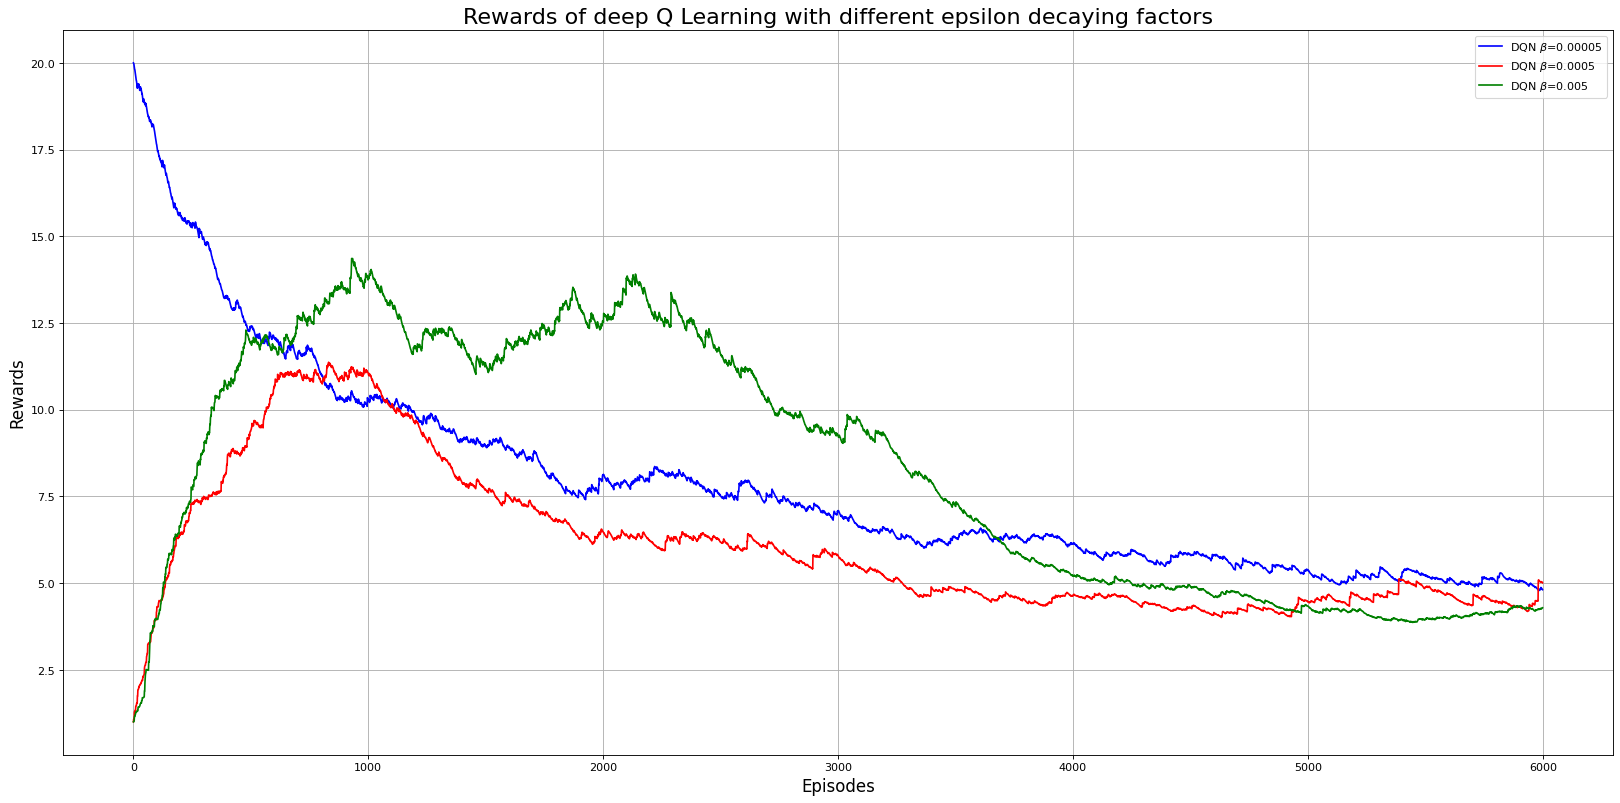

In [66]:
ema_dqn_move = exponential_moving_average(N_moves_save,alpha)
ema_dqn_move_beta1 = exponential_moving_average(N_moves_save_beta_change1,alpha)
ema_dqn_move_beta2 = exponential_moving_average(N_moves_save_beta_change2,alpha)

plt.figure(figsize=(25, 12), dpi=80)
    
plt.plot(ema_dqn_move[:6000],color = "b",label='DQN $β$=0.00005')
plt.plot(ema_dqn_move_beta1[:6000],color = "r",label='DQN $β$=0.0005')
plt.plot(ema_dqn_move_beta2[:6000],color = "g",label='DQN $β$=0.005')

plt.legend()

plt.title('Rewards of deep Q Learning with different epsilon decaying factors',fontsize = 20)
plt.ylabel('Rewards',fontsize = 15)
plt.xlabel('Episodes',fontsize = 15)
plt.grid(True,which='major')

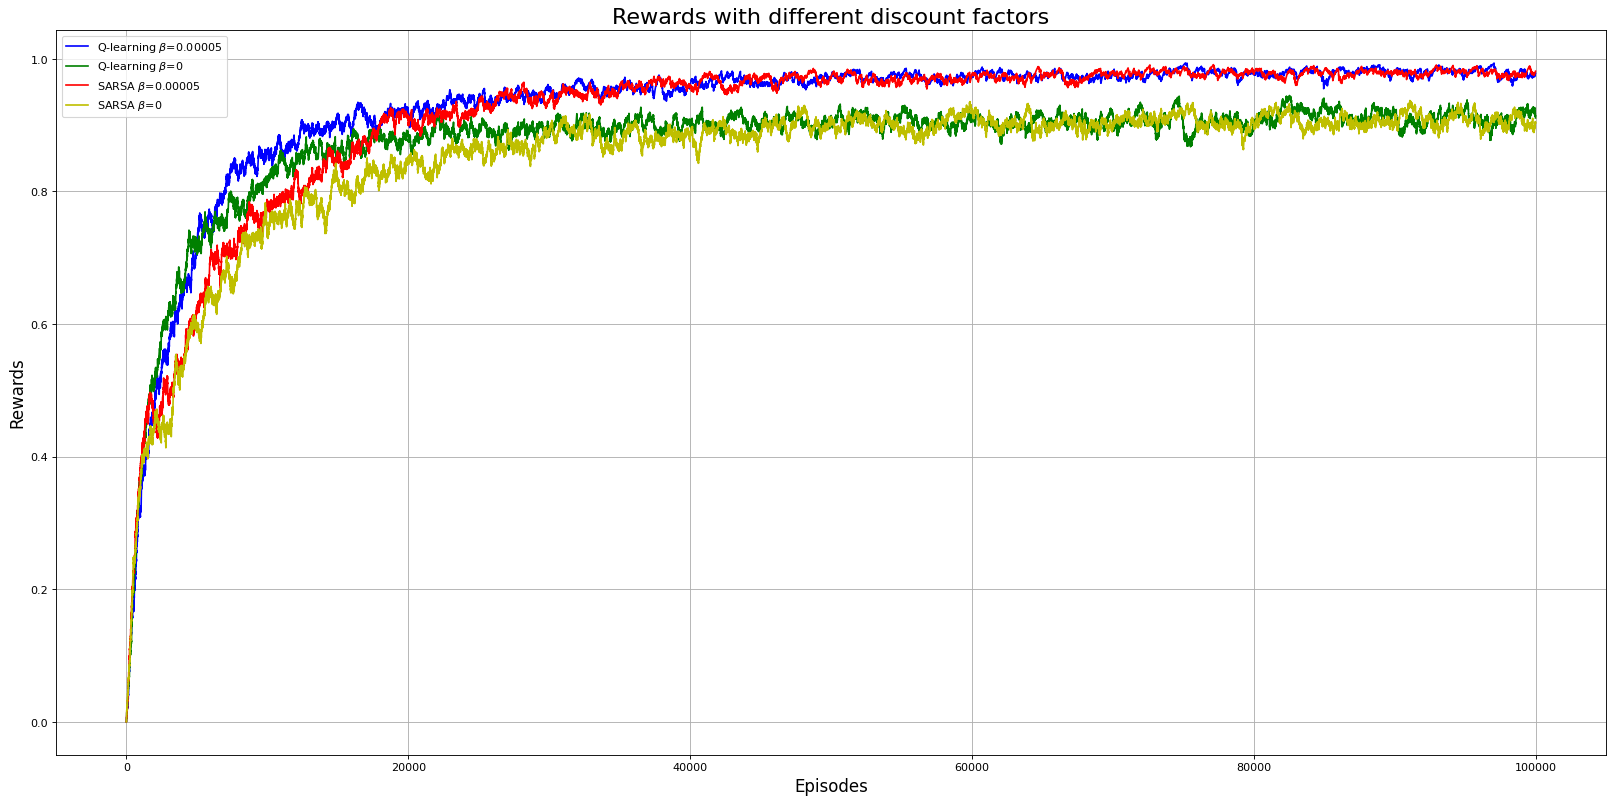

In [31]:
ema_dqn_save = exponential_moving_average(R_save,alpha)
ema_dqn_beta3 = exponential_moving_average(R_save_beta_change3,alpha)

ema_sarsa = exponential_moving_average(R_save_sarsa,alpha)
ema_sarsa_beta = exponential_moving_average(R_save_sarsa_beta,alpha)

plt.figure(figsize=(25, 12), dpi=80)

plt.plot(ema_dqn_save,color = "b",label='Q-learning $β$=0.00005')
plt.plot(ema_dqn_beta3,color = "g",label='Q-learning $β$=0')

plt.plot(ema_sarsa,color = "r",label='SARSA $β$=0.00005')
plt.plot(ema_sarsa_beta,color = "y",label='SARSA $β$=0')


plt.legend()

plt.title('Rewards with different discount factors',fontsize = 20)
plt.ylabel('Rewards',fontsize = 15)
plt.xlabel('Episodes',fontsize = 15)
plt.grid(True,which='major')

This graph shows that when the β equals 0,ϵ
is unchanged during training process. In the end, both
Q-learning and SARSA can only converge to an ϵ-optimal
level(a near-optimal level) instead of the optimal level since
they are both using ϵ-greedy policy.When β doesn’t equal 0,
both of the curve can gradually converges to 1, the optimal
level.
                    

This part might seem counter-intuitive, because Q-learning
learns the optimal strategy but it still converges to only the
ϵ-optimal level. The reason is that when β equals 0, in state
a, both methods will still use the ϵ-greedy policy with the
unchanged ϵ. Even if model is well-trained already, the agent
with such a policy won’t always choose the optimal action,
so the rewards can’t always be optimal. Now, we consider
how different β influences the training.

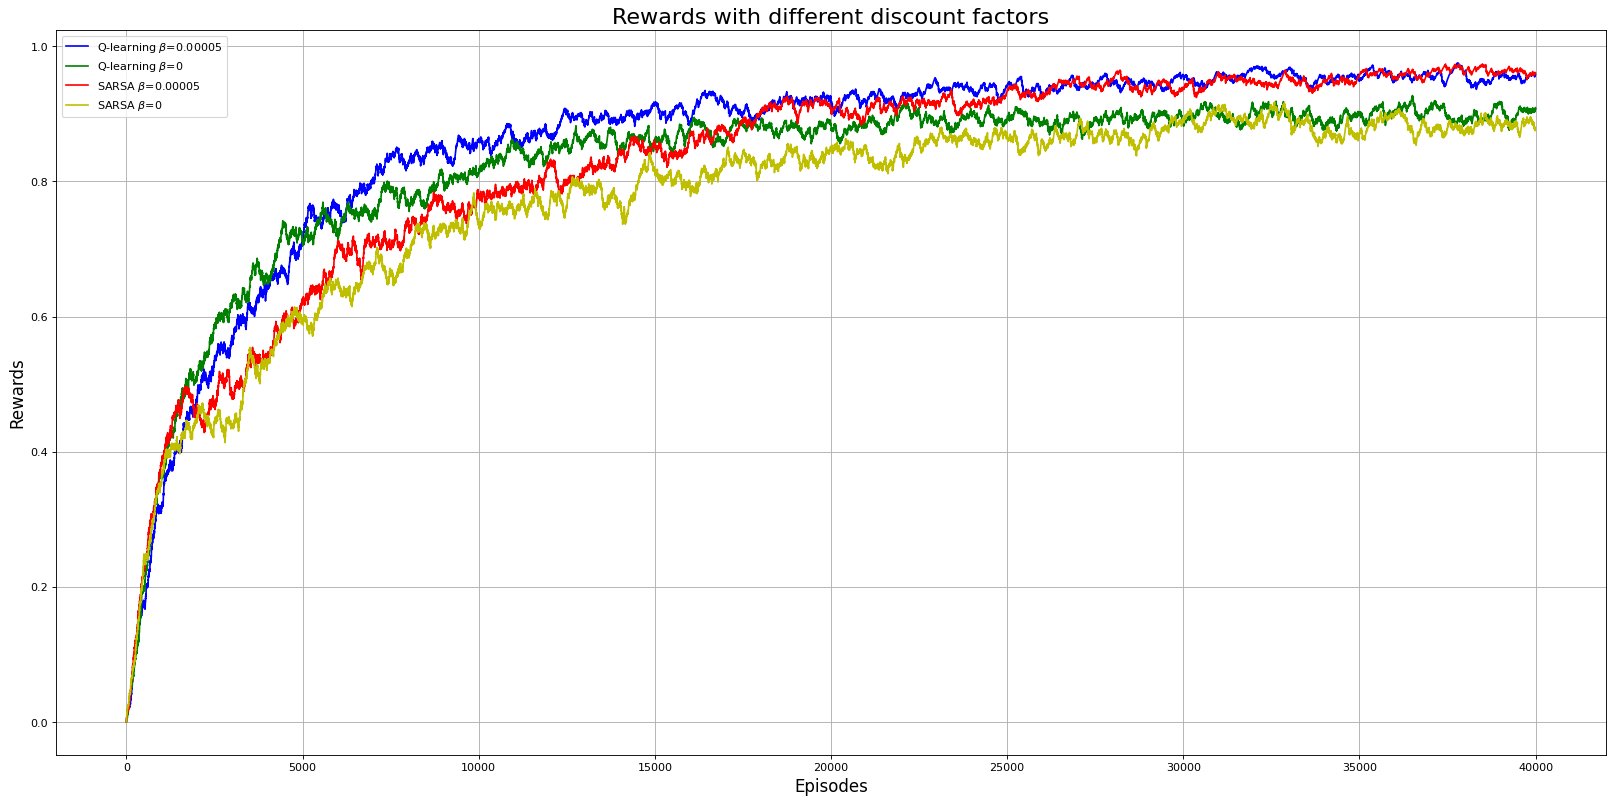

In [34]:
ema_dqn_save = exponential_moving_average(R_save,alpha)
ema_dqn_beta3 = exponential_moving_average(R_save_beta_change3,alpha)

ema_sarsa = exponential_moving_average(R_save_sarsa,alpha)
ema_sarsa_beta = exponential_moving_average(R_save_sarsa_beta,alpha)

plt.figure(figsize=(25, 12), dpi=80)

plt.plot(ema_dqn_save[:40000],color = "b",label='Q-learning $β$=0.00005')
plt.plot(ema_dqn_beta3[:40000],color = "g",label='Q-learning $β$=0')

plt.plot(ema_sarsa[:40000],color = "r",label='SARSA $β$=0.00005')
plt.plot(ema_sarsa_beta[:40000],color = "y",label='SARSA $β$=0')


plt.legend()

plt.title('Rewards with different discount factors',fontsize = 20)
plt.ylabel('Rewards',fontsize = 15)
plt.xlabel('Episodes',fontsize = 15)
plt.grid(True,which='major')

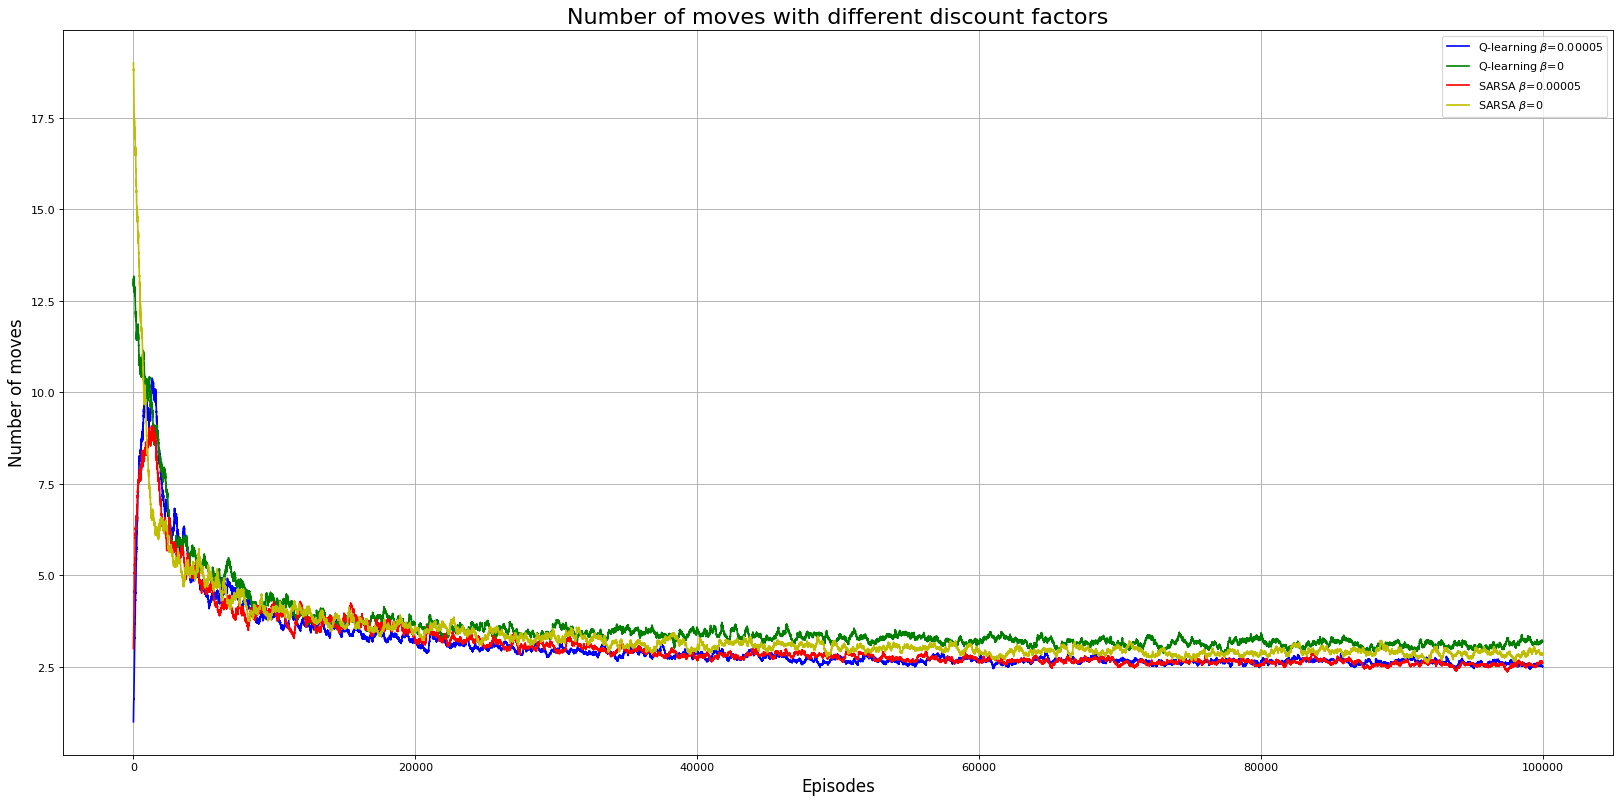

In [29]:
ema_dqn_move_save = exponential_moving_average(N_moves_save,alpha)
ema_dqn_move_beta3 = exponential_moving_average(N_moves_save_beta_change3,alpha)

ema_move_sarsa = exponential_moving_average(N_moves_save_sarsa,alpha)
ema_move_sarsa_beta = exponential_moving_average(N_moves_save_sarsa_beta,alpha)

plt.figure(figsize=(25, 12), dpi=80)

plt.plot(ema_dqn_move_save[:4000],color = "b",label='Q-learning $β$=0.00005')
plt.plot(ema_dqn_move_beta3[:4000],color = "g",label='Q-learning $β$=0')

plt.plot(ema_move_sarsa[:4000],color = "r",label='SARSA $β$=0.00005')
plt.plot(ema_move_sarsa_beta[:4000],color = "y",label='SARSA $β$=0')


plt.legend()

plt.title('Number of moves with different discount factors',fontsize = 20)
plt.ylabel('Number of moves',fontsize = 15)
plt.xlabel('Episodes',fontsize = 15)
plt.grid(True,which='major')





## Conclusion

The experiment shows that in such a not complicated
binary-rewarding environment:
- 1. Q-learning converges faster than SARSA in this case.
- 2. The higher the γ, the faster the algorithm converges to
the optimal level.
- 3. The higher the β, the faster the algorithm converge to the
optimal level (once the agent has enough exploration).Without
the decaying-epsilon strategy, both the Q-learning and SARSA
will converges to an ϵ-optimal level in stead of the optional
level
V